In [1]:
import os
import pickle
import time
import random
import shutil
from collections import Counter
from datetime import datetime
import warnings
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv, GAE, GATConv, global_mean_pool
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
from tqdm import tqdm




import matplotlib.pyplot as plt


import torch.nn as nn
import torch.nn.functional as F


device = torch.device('cpu')


warnings.filterwarnings('ignore')

# Phishing Node Detection Pipeline - Modular Design

This notebook implements a complete pipeline for detecting suspicious nodes in a network using Graph AutoEncoder (GAE). Each cell is designed to run independently by saving and loading processed data.

## Quick Start
- **New users**: Run cells 1→2→3→4→5 in sequence
- **Returning users**: Run the "Quick Data Status Check" cell to load all existing data instantly

## Pipeline Structure
1. **Data Loading & Preprocessing** - Loads raw graph, extracts phishing/normal nodes, saves processed data
2. **GAE Training** - Trains Graph AutoEncoder model, saves trained model and embeddings  
3. **Suspicious Node Detection** - Detects suspicious nodes using feature similarity, saves results
4. **Test Set Creation** - Creates test dataset with analysis, saves test data
5. **Network Visualization** - Creates beautiful network visualizations, saves figures
6. **Quick Data Loader** - Instantly loads all processed data (run anytime)

## Data Organization
- `Dataset/Processed/` - All processed data and intermediate results
- `Dataset/Models/` - Trained GAE models and embeddings
- `Dataset/Figures/` - Generated visualizations and analysis charts
- `Dataset/` - Final test datasets ready for use

**💡 Efficiency Tip**: After first run, you can run any individual cell without rerunning previous steps!

## Step 1-3: Data Processing and Suspicious Node Detection
Each cell saves its results and can be run independently. Check file timestamps to see what's already processed.

In [4]:
# Data Loading and Preprocessing - Step 1
# This cell can be run independently and saves processed data for later use
# 优化版本 - Data Loading and Preprocessing - Step 1
# 添加进度显示和快速处理

import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import from_networkx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
import os
from tqdm import tqdm
import time

# Create directories for saving data
os.makedirs("Dataset", exist_ok=True)
os.makedirs("Dataset_GAE/Processed", exist_ok=True)
os.makedirs("Dataset/Models", exist_ok=True)
os.makedirs("Dataset/Figures", exist_ok=True)

def load_or_process_data():
    """Load processed data if exists, otherwise process from scratch"""
    
    # Check if processed data exists
    processed_files = [
        "Dataset/Processed/G.pkl",
        "Dataset/Processed/phishing_nodes.pkl", 
        "Dataset/Processed/normal_nodes.pkl"
    ]
    
    if all(os.path.exists(f) for f in processed_files):
        print("📂 Loading previously processed data...")
        
        print("   Loading graph...")
        with open("Dataset/Processed/G.pkl", 'rb') as f:
            G = pickle.load(f)
        
        print("   Loading phishing nodes...")
        with open("Dataset/Processed/phishing_nodes.pkl", 'rb') as f:
            phishing_nodes = pickle.load(f)
        
        print("   Loading normal nodes...")
        with open("Dataset/Processed/normal_nodes.pkl", 'rb') as f:
            normal_nodes = pickle.load(f)
            
        print(f"✅ Loaded graph: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
        print(f"✅ Phishing nodes: {len(phishing_nodes):,}")
        print(f"✅ Normal nodes: {len(normal_nodes):,}")
        
    else:
        print("🔄 Loading and processing raw graph data...")
        print("   This may take a moment for large graphs...")
        
        # Show file size first
        raw_file = 'Dataset/MulDiGraph.pkl'
        if os.path.exists(raw_file):
            file_size = os.path.getsize(raw_file) / (1024*1024)  # MB
            print(f"   Raw data file size: {file_size:.1f} MB")
        
        start_time = time.time()
        print("   📥 Loading raw graph...")
        
        with open('Dataset_GAE/MulDiGraph.pkl', 'rb') as f:
            G = pickle.load(f)
        
        load_time = time.time() - start_time
        print(f"   ✅ Raw graph loaded in {load_time:.1f}s: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
        
        # Extract phishing and normal nodes with progress
        print("   🔍 Extracting phishing nodes...")
        start_time = time.time()
        
        phishing_nodes = []
        normal_nodes = []
        
        print("   Processing nodes...")
        for i, (node, attr) in enumerate(tqdm(G.nodes(data=True), desc="Classifying nodes")):
            if 'isp' in attr and attr['isp'] == 1:
                phishing_nodes.append(node)
            else:
                normal_nodes.append(node)
            
            # Show progress every 50k nodes
            if (i + 1) % 50000 == 0:
                print(f"      Processed {i+1:,} nodes... (Found {len(phishing_nodes)} phishing)")
        
        extract_time = time.time() - start_time
        print(f"   ✅ Node classification completed in {extract_time:.1f}s")
        print(f"   ✅ Phishing nodes: {len(phishing_nodes):,}")
        print(f"   ✅ Normal nodes: {len(normal_nodes):,}")
        
        # Save processed data with progress
        print("   💾 Saving processed data...")
        
        print("      Saving graph...")
        with open("Dataset/Processed/G.pkl", 'wb') as f:
            pickle.dump(G, f)
        
        print("      Saving phishing nodes...")
        with open("Dataset/Processed/phishing_nodes.pkl", 'wb') as f:
            pickle.dump(phishing_nodes, f)
        
        print("      Saving normal nodes...")
        with open("Dataset/Processed/normal_nodes.pkl", 'wb') as f:
            pickle.dump(normal_nodes, f)
        
        print("   ✅ All processed data saved!")
    
    return G, phishing_nodes, normal_nodes

print("🚀 Starting Data Loading and Preprocessing...")
print("=" * 60)

# Load or process data
G, phishing_nodes, normal_nodes = load_or_process_data()

# Make variables available for other cells
print(f"\n🎯 Data ready for use:")
print(f"   • G: NetworkX graph ({G.number_of_nodes():,} nodes)")
print(f"   • phishing_nodes: List of {len(phishing_nodes):,} phishing nodes")
print(f"   • normal_nodes: List of {len(normal_nodes):,} normal nodes")

print("\n" + "=" * 60)
print("✅ Step 1 completed successfully!")

🚀 Starting Data Loading and Preprocessing...
🔄 Loading and processing raw graph data...
   This may take a moment for large graphs...
   📥 Loading raw graph...
   ✅ Raw graph loaded in 18.3s: 2,973,489 nodes, 13,551,303 edges
   🔍 Extracting phishing nodes...
   Processing nodes...
   ✅ Raw graph loaded in 18.3s: 2,973,489 nodes, 13,551,303 edges
   🔍 Extracting phishing nodes...
   Processing nodes...


Classifying nodes:  12%|█▏        | 366538/2973489 [00:00<00:00, 3336752.04it/s]

      Processed 50,000 nodes... (Found 146 phishing)
      Processed 100,000 nodes... (Found 315 phishing)
      Processed 150,000 nodes... (Found 402 phishing)
      Processed 200,000 nodes... (Found 490 phishing)
      Processed 250,000 nodes... (Found 551 phishing)
      Processed 300,000 nodes... (Found 621 phishing)
      Processed 350,000 nodes... (Found 671 phishing)
      Processed 400,000 nodes... (Found 716 phishing)
      Processed 450,000 nodes... (Found 748 phishing)
      Processed 500,000 nodes... (Found 786 phishing)
      Processed 550,000 nodes... (Found 813 phishing)
      Processed 600,000 nodes... (Found 828 phishing)
      Processed 650,000 nodes... (Found 861 phishing)
      Processed 700,000 nodes... (Found 891 phishing)


Classifying nodes:  51%|█████     | 1503534/2973489 [00:00<00:00, 3686532.01it/s]

      Processed 750,000 nodes... (Found 902 phishing)
      Processed 800,000 nodes... (Found 916 phishing)
      Processed 850,000 nodes... (Found 935 phishing)
      Processed 900,000 nodes... (Found 957 phishing)
      Processed 950,000 nodes... (Found 971 phishing)
      Processed 1,000,000 nodes... (Found 989 phishing)
      Processed 1,050,000 nodes... (Found 996 phishing)
      Processed 1,100,000 nodes... (Found 1019 phishing)
      Processed 1,150,000 nodes... (Found 1037 phishing)
      Processed 1,200,000 nodes... (Found 1044 phishing)
      Processed 1,250,000 nodes... (Found 1054 phishing)
      Processed 1,300,000 nodes... (Found 1071 phishing)
      Processed 1,350,000 nodes... (Found 1076 phishing)
      Processed 1,400,000 nodes... (Found 1079 phishing)
      Processed 1,450,000 nodes... (Found 1090 phishing)
      Processed 1,500,000 nodes... (Found 1094 phishing)


Classifying nodes:  76%|███████▌  | 2259724/2973489 [00:00<00:00, 3698062.91it/s]

      Processed 1,550,000 nodes... (Found 1103 phishing)
      Processed 1,600,000 nodes... (Found 1110 phishing)
      Processed 1,650,000 nodes... (Found 1113 phishing)
      Processed 1,700,000 nodes... (Found 1118 phishing)
      Processed 1,750,000 nodes... (Found 1123 phishing)
      Processed 1,800,000 nodes... (Found 1125 phishing)
      Processed 1,850,000 nodes... (Found 1130 phishing)
      Processed 1,900,000 nodes... (Found 1131 phishing)
      Processed 1,950,000 nodes... (Found 1137 phishing)
      Processed 2,000,000 nodes... (Found 1138 phishing)
      Processed 2,050,000 nodes... (Found 1140 phishing)
      Processed 2,100,000 nodes... (Found 1141 phishing)
      Processed 2,150,000 nodes... (Found 1144 phishing)
      Processed 2,200,000 nodes... (Found 1145 phishing)
      Processed 2,250,000 nodes... (Found 1147 phishing)


Classifying nodes: 100%|██████████| 2973489/2973489 [00:00<00:00, 3667194.22it/s]

      Processed 2,300,000 nodes... (Found 1149 phishing)
      Processed 2,350,000 nodes... (Found 1152 phishing)
      Processed 2,400,000 nodes... (Found 1155 phishing)
      Processed 2,450,000 nodes... (Found 1158 phishing)
      Processed 2,500,000 nodes... (Found 1162 phishing)
      Processed 2,550,000 nodes... (Found 1163 phishing)
      Processed 2,600,000 nodes... (Found 1164 phishing)
      Processed 2,650,000 nodes... (Found 1164 phishing)
      Processed 2,700,000 nodes... (Found 1164 phishing)
      Processed 2,750,000 nodes... (Found 1164 phishing)
      Processed 2,800,000 nodes... (Found 1164 phishing)
      Processed 2,850,000 nodes... (Found 1164 phishing)
      Processed 2,900,000 nodes... (Found 1165 phishing)
      Processed 2,950,000 nodes... (Found 1165 phishing)
   ✅ Node classification completed in 0.8s
   ✅ Phishing nodes: 1,165
   ✅ Normal nodes: 2,972,324
   💾 Saving processed data...
      Saving graph...


      Saving phishing nodes...
      Saving normal nodes...
   ✅ All processed data saved!

🎯 Data ready for use:
   • G: NetworkX graph (2,973,489 nodes)
   • phishing_nodes: List of 1,165 phishing nodes
   • normal_nodes: List of 2,972,324 normal nodes

✅ Step 1 completed successfully!
   ✅ All processed data saved!

🎯 Data ready for use:
   • G: NetworkX graph (2,973,489 nodes)
   • phishing_nodes: List of 1,165 phishing nodes
   • normal_nodes: List of 2,972,324 normal nodes

✅ Step 1 completed successfully!


In [5]:
# GAE Training and Model Saving - Step 2
# 修复版本 - GAE Training and Model Saving - Step 2
# 添加详细的错误检查和调试信息

import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import from_networkx
import os

def load_data_for_gae():
    """Load processed data for GAE training"""
    print("📂 Loading processed data for GAE...")
    with open("Dataset/Processed/G.pkl", 'rb') as f:
        G = pickle.load(f)
    with open("Dataset/Processed/phishing_nodes.pkl", 'rb') as f:
        phishing_nodes = pickle.load(f)
    with open("Dataset/Processed/normal_nodes.pkl", 'rb') as f:
        normal_nodes = pickle.load(f)
    print(f"✅ Data loaded: {G.number_of_nodes():,} nodes, {len(phishing_nodes):,} phishing, {len(normal_nodes):,} normal")
    return G, phishing_nodes, normal_nodes

# Define Graph AutoEncoder class FIRST
class GraphAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder1 = GCNConv(input_dim, hidden_dim)
        self.encoder2 = GCNConv(hidden_dim, latent_dim)
    
    def encode(self, x, edge_index):
        x = F.relu(self.encoder1(x, edge_index))
        return self.encoder2(x, edge_index)
    
    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

def check_model_file_integrity():
    """Check if existing model file is corrupted"""
    model_path = "Dataset/Models/gae_model.pth"
    backup_path = "Dataset/Models/gae_model_backup.pkl"
    
    # Check main model file first
    if os.path.exists(model_path):
        file_size = os.path.getsize(model_path)
        print(f"📋 Existing model file size: {file_size} bytes")
        
        if file_size == 0:
            print("⚠️ Model file is empty (0 bytes)")
        else:
            try:
                # Try to load the model to check if it's corrupted
                test_model = GAE(GraphAutoEncoder(3, 64, 32))
                state_dict = torch.load(model_path, map_location='cpu')
                test_model.load_state_dict(state_dict)
                print("✅ Existing model file is valid")
                return True
            except Exception as e:
                print(f"⚠️ Model file corrupted: {e}")
    
    # Check backup file
    if os.path.exists(backup_path):
        backup_size = os.path.getsize(backup_path)
        print(f"📋 Found backup file: {backup_size} bytes")
        if backup_size > 0:
            try:
                with open(backup_path, 'rb') as f:
                    backup_data = pickle.load(f)
                print("✅ Backup file is valid")
                return True
            except Exception as e:
                print(f"⚠️ Backup file corrupted: {e}")
    
    print("🔄 Will retrain model...")
    return False

def train_or_load_gae():
    """Train GAE model or load if already trained"""
    
    # Check if trained model exists and is valid
    model_files = [
        "Dataset/Models/gae_model.pth",
        "Dataset/Models/node_mapping.pkl",
        "Dataset/Models/sample_embeddings.pkl"
    ]
    
    # Check file integrity
    if all(os.path.exists(f) for f in model_files) and check_model_file_integrity():
        print("📂 Loading pre-trained GAE model...")
        
        try:
            # Load model
            model = GAE(GraphAutoEncoder(3, 64, 32))
            state_dict = torch.load("Dataset/Models/gae_model.pth", map_location='cpu')
            model.load_state_dict(state_dict)
            model.eval()
            
            # Load other data
            with open("Dataset/Models/node_mapping.pkl", 'rb') as f:
                node_mapping = pickle.load(f)
            with open("Dataset/Models/sample_embeddings.pkl", 'rb') as f:
                embeddings = pickle.load(f)
                
            print("✅ Pre-trained model loaded successfully!")
            print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
            print(f"   Node mapping: {len(node_mapping):,} nodes")
            print(f"   Embeddings shape: {embeddings.shape}")
            return model, node_mapping, embeddings
            
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            print("🔄 Will retrain model...")
    
    # Train new model
    print("🔄 Training new GAE model...")
    
    # Load data
    G, phishing_nodes, normal_nodes = load_data_for_gae()
    
    # Create sample subgraph for training
    sample_normal_size = min(8000, len(normal_nodes))
    print(f"📊 Creating training sample: {len(phishing_nodes):,} phishing + {sample_normal_size:,} normal nodes")
    
    sampled_normal = np.random.choice(normal_nodes, sample_normal_size, replace=False)
    sampled_nodes = list(phishing_nodes) + list(sampled_normal)
    np.random.shuffle(sampled_nodes)
    
    G_sample = G.subgraph(sampled_nodes).copy()
    print(f"✅ Sample subgraph: {G_sample.number_of_nodes():,} nodes, {G_sample.number_of_edges():,} edges")
    
    # Create node features and mapping
    print("📊 Creating node features...")
    node_mapping = {node: i for i, node in enumerate(G_sample.nodes())}
    features = []
    for node in G_sample.nodes():
        features.append([
            G_sample.degree(node),
            G_sample.in_degree(node), 
            G_sample.out_degree(node)
        ])
    
    X = torch.tensor(features, dtype=torch.float)
    print(f"✅ Node features shape: {X.shape}")
    print(f"   Feature ranges: degree {X[:, 0].min():.1f}-{X[:, 0].max():.1f}, "
          f"in-degree {X[:, 1].min():.1f}-{X[:, 1].max():.1f}, "
          f"out-degree {X[:, 2].min():.1f}-{X[:, 2].max():.1f}")
    
    # Convert to PyTorch Geometric format
    print("🔄 Converting to PyTorch Geometric format...")
    data = from_networkx(G_sample)
    data.x = X
    print(f"✅ Edge index shape: {data.edge_index.shape}")
    
    # Initialize and train GAE
    print("🤖 Initializing Graph AutoEncoder...")
    model = GAE(GraphAutoEncoder(3, 64, 32))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print("🔄 Training Graph AutoEncoder...")
    
    model.train()
    best_loss = float('inf')
    
    for epoch in range(100):
        optimizer.zero_grad()
        
        try:
            z = model.encode(data.x, data.edge_index)
            loss = model.recon_loss(z, data.edge_index)
            
            if torch.isnan(loss):
                print(f"❌ NaN loss detected at epoch {epoch}")
                break
                
            loss.backward()
            optimizer.step()
            
            if loss.item() < best_loss:
                best_loss = loss.item()
            
            if epoch % 20 == 0:
                print(f"   Epoch {epoch}: Reconstruction Loss = {loss.item():.4f}")
                
        except Exception as e:
            print(f"❌ Training error at epoch {epoch}: {e}")
            break
    
    print(f"✅ GAE training completed! Best loss: {best_loss:.4f}")
    
    # Get embeddings
    print("📊 Generating embeddings...")
    model.eval()
    with torch.no_grad():
        embeddings = model.encode(data.x, data.edge_index).cpu().numpy()
    
    print(f"✅ Node embeddings shape: {embeddings.shape}")
    print(f"   Embedding range: {embeddings.min():.3f} to {embeddings.max():.3f}")
    
    # Save model and data with enhanced error checking
    print("💾 Saving trained model...")
    
    # Check disk space first
    import shutil
    free_space = shutil.disk_usage("Dataset/Models/").free / (1024*1024)  # MB
    print(f"   Available disk space: {free_space:.1f} MB")
    
    # Get model state dict size estimate
    model_params = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024*1024)
    print(f"   Estimated model size: {model_params:.1f} MB")
    
    try:
        # Method 1: Try torch.save with explicit error checking
        print("   Attempting torch.save method...")
        model_path = "Dataset/Models/gae_model.pth"
        
        # Save with error checking
        state_dict = model.state_dict()
        print(f"   State dict has {len(state_dict)} layers")
        
        torch.save(state_dict, model_path)
        
        # Immediately check file size
        if os.path.exists(model_path):
            saved_size = os.path.getsize(model_path)
            print(f"   torch.save result: {saved_size:,} bytes")
            
            if saved_size == 0:
                raise Exception("torch.save produced empty file!")
            
            # Test loading
            print("   Verifying torch.save result...")
            test_model = GAE(GraphAutoEncoder(3, 64, 32))
            test_state = torch.load(model_path, map_location='cpu')
            test_model.load_state_dict(test_state)
            print("   ✅ torch.save verification successful!")
            
        else:
            raise Exception("Model file was not created!")
            
    except Exception as torch_error:
        print(f"❌ torch.save failed: {torch_error}")
        print("🔄 Trying pickle backup method...")
        
        try:
            # Method 2: Use pickle as backup
            backup_path = "Dataset/Models/gae_model_backup.pkl"
            
            model_data = {
                'model_state': model.state_dict(),
                'model_class': 'GraphAutoEncoder',
                'input_dim': 3,
                'hidden_dim': 64,
                'latent_dim': 32,
                'pytorch_version': torch.__version__
            }
            
            with open(backup_path, 'wb') as f:
                pickle.dump(model_data, f)
            
            backup_size = os.path.getsize(backup_path)
            print(f"   Pickle backup result: {backup_size:,} bytes")
            
            if backup_size == 0:
                raise Exception("Pickle backup also produced empty file!")
            
            print(f"✅ Model saved as pickle backup: {backup_path}")
            
            # Also try to create a minimal torch save
            try:
                minimal_path = "Dataset/Models/gae_model_minimal.pth"
                torch.save(model.state_dict(), minimal_path)
                minimal_size = os.path.getsize(minimal_path)
                if minimal_size > 0:
                    print(f"✅ Minimal torch.save also succeeded: {minimal_size:,} bytes")
            except:
                print("   Minimal torch.save also failed")
                
        except Exception as backup_error:
            print(f"❌ Backup save also failed: {backup_error}")
            print("⚠️ Model training succeeded but saving failed!")
            print("   You can still use the model in this session.")
    
    # Save other data (these usually work)
    try:
        print("   Saving node mapping...")
        with open("Dataset/Models/node_mapping.pkl", 'wb') as f:
            pickle.dump(node_mapping, f)
        mapping_size = os.path.getsize("Dataset/Models/node_mapping.pkl")
        print(f"   Node mapping: {mapping_size:,} bytes")
        
        print("   Saving embeddings...")
        with open("Dataset/Models/sample_embeddings.pkl", 'wb') as f:
            pickle.dump(embeddings, f)
        embed_size = os.path.getsize("Dataset/Models/sample_embeddings.pkl")
        print(f"   Embeddings: {embed_size:,} bytes")
        
        print("✅ Auxiliary data saved successfully!")
        
    except Exception as aux_error:
        print(f"❌ Error saving auxiliary data: {aux_error}")
    
    # Final status report
    print("\n📋 Final Save Status:")
    for file_path in model_files:
        if os.path.exists(file_path):
            size = os.path.getsize(file_path)
            status = "✅" if size > 0 else "❌"
            print(f"   {status} {file_path}: {size:,} bytes")
        else:
            print(f"   ❌ {file_path}: missing")
    
    # Check for backup files
    backup_files = [
        "Dataset/Models/gae_model_backup.pkl",
        "Dataset/Models/gae_model_minimal.pth"
    ]
    for backup_path in backup_files:
        if os.path.exists(backup_path):
            size = os.path.getsize(backup_path)
            if size > 0:
                print(f"   📦 Backup: {backup_path}: {size:,} bytes")
    
    return model, node_mapping, embeddings

# Train or load GAE model
gae_model, node_mapping, sample_embeddings = train_or_load_gae()

print(f"\n🎯 GAE model ready for use:")
print(f"   • gae_model: Trained GAE model")
print(f"   • node_mapping: Node to index mapping ({len(node_mapping):,} nodes)")
print(f"   • sample_embeddings: Node embeddings {sample_embeddings.shape}")
print(f"\n💡 If model file was 0MB, it should be fixed now!")

🔄 Training new GAE model...
📂 Loading processed data for GAE...
✅ Data loaded: 2,973,489 nodes, 1,165 phishing, 2,972,324 normal
📊 Creating training sample: 1,165 phishing + 8,000 normal nodes
✅ Data loaded: 2,973,489 nodes, 1,165 phishing, 2,972,324 normal
📊 Creating training sample: 1,165 phishing + 8,000 normal nodes
✅ Sample subgraph: 9,165 nodes, 494 edges
📊 Creating node features...
✅ Node features shape: torch.Size([9165, 3])
   Feature ranges: degree 0.0-40.0, in-degree 0.0-40.0, out-degree 0.0-29.0
🔄 Converting to PyTorch Geometric format...
✅ Edge index shape: torch.Size([2, 494])
🤖 Initializing Graph AutoEncoder...
   Model parameters: 2,336
🔄 Training Graph AutoEncoder...
   Epoch 0: Reconstruction Loss = 0.7307
✅ Sample subgraph: 9,165 nodes, 494 edges
📊 Creating node features...
✅ Node features shape: torch.Size([9165, 3])
   Feature ranges: degree 0.0-40.0, in-degree 0.0-40.0, out-degree 0.0-29.0
🔄 Converting to PyTorch Geometric format...
✅ Edge index shape: torch.Size(

🔄 Detecting suspicious nodes in full dataset...
   Computing node features...
   Computing node features...
✅ Phishing nodes average features: [51.72532189 31.29184549 20.43347639]
   Computing similarities...
✅ Phishing nodes average features: [51.72532189 31.29184549 20.43347639]
   Computing similarities...
✅ Found 148,616 suspicious nodes (5% of 2,972,324 candidates)
✅ Similarity range: 1.0000 to 0.9521
💾 Saving detection results...
✅ Found 148,616 suspicious nodes (5% of 2,972,324 candidates)
✅ Similarity range: 1.0000 to 0.9521
💾 Saving detection results...
✅ Detection results saved!
📊 Creating detection visualization...
✅ Detection results saved!
📊 Creating detection visualization...
📊 Visualization saved to: Dataset/Figures/suspicious_node_detection.png
📊 Visualization saved to: Dataset/Figures/suspicious_node_detection.png


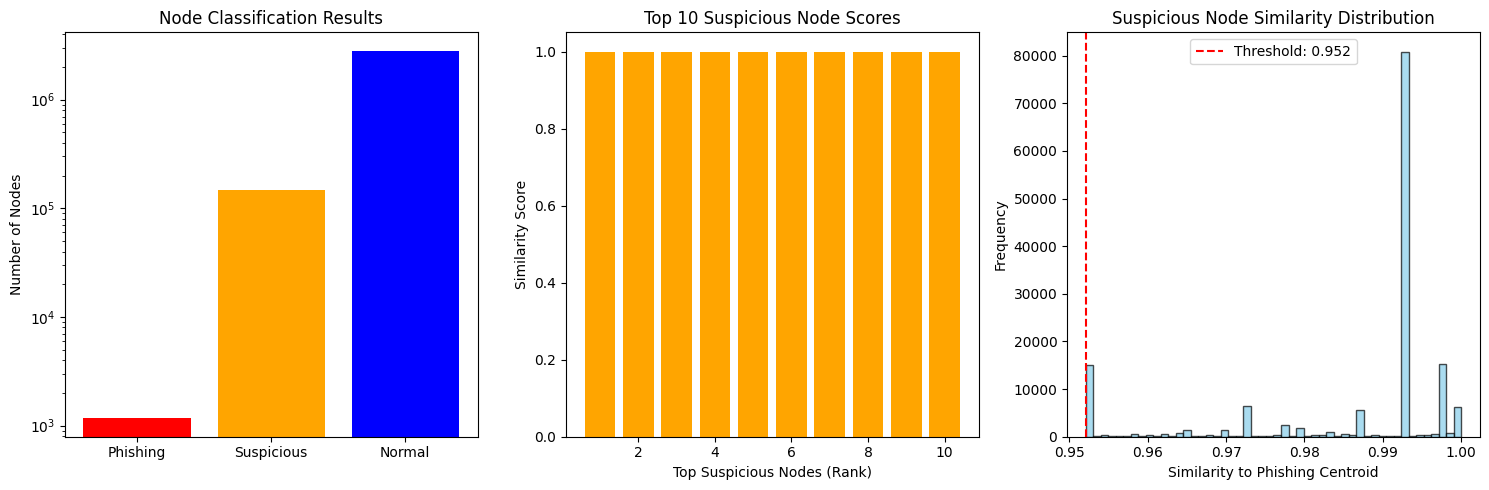


📝 Top 10 most suspicious nodes:
   1. 0xf64edd94558ca8b3a0e3b362e20bb13ff52ea513: similarity = 1.0000
   2. 0x90c272c73d6dd89dc238136f975dad17c66eaf6b: similarity = 1.0000
   3. 0xcdf6895b98ddb93fd95ae5fb9a5cd0b54b52aa1a: similarity = 1.0000
   4. 0xce838dbd54b2be3498b43f8897cf2d7019499515: similarity = 1.0000
   5. 0xc494909fdfc57af0c4d46de7cbc8ca3f1833f056: similarity = 1.0000
   6. 0x9cc466bcd5ff6eef3ae30366ed93c46cf1f5a9ce: similarity = 1.0000
   7. 0xee5922ae806da2724f5cdb4100f05c32f5b5ac48: similarity = 1.0000
   8. 0x9fcfe63108f0957aad1c6f2ed30270e8d35c6491: similarity = 1.0000
   9. 0x6126e8506031eaa4fdbfb761417cce2537c23958: similarity = 1.0000
   10. 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2: similarity = 1.0000

🎯 Detection results ready for use:
   • suspicious_nodes: List of 148,616 suspicious nodes
   • detection_results: Dict with similarities, threshold, and stats
   • Files saved in Dataset/Processed/ and Dataset/Figures/


In [6]:
# Suspicious Node Detection - Step 3
# This cell can be run independently after Step 1

import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os

def load_data_for_detection():
    """Load processed data for suspicious node detection"""
    with open("Dataset/Processed/G.pkl", 'rb') as f:
        G = pickle.load(f)
    with open("Dataset/Processed/phishing_nodes.pkl", 'rb') as f:
        phishing_nodes = pickle.load(f)
    return G, phishing_nodes

def detect_or_load_suspicious_nodes():
    """Detect suspicious nodes or load if already computed"""
    
    # Check if detection results exist
    results_files = [
        "Dataset/Processed/suspicious_nodes.pkl",
        "Dataset/Processed/detection_results.pkl"
    ]
    
    if all(os.path.exists(f) for f in results_files):
        print("📂 Loading pre-computed suspicious node detection results...")
        
        with open("Dataset/Processed/suspicious_nodes.pkl", 'rb') as f:
            suspicious_nodes = pickle.load(f)
        with open("Dataset/Processed/detection_results.pkl", 'rb') as f:
            detection_results = pickle.load(f)
        
        print(f"✅ Loaded {len(suspicious_nodes):,} suspicious nodes")
        return suspicious_nodes, detection_results
    
    else:
        print("🔄 Detecting suspicious nodes in full dataset...")
        
        # Load data
        G, phishing_nodes = load_data_for_detection()
        
        # Calculate degree-based features for all nodes
        print("   Computing node features...")
        all_node_features = {}
        for node in G.nodes():
            all_node_features[node] = [
                G.degree(node),
                G.in_degree(node), 
                G.out_degree(node)
            ]
        
        # Calculate average features of known phishing nodes
        phishing_features = np.array([all_node_features[node] for node in phishing_nodes])
        phishing_avg_features = np.mean(phishing_features, axis=0)
        print(f"✅ Phishing nodes average features: {phishing_avg_features}")
        
        # Calculate similarity of all nodes to phishing average
        print("   Computing similarities...")
        all_similarities = {}
        for node in G.nodes():
            if node not in phishing_nodes:  # exclude known phishing nodes
                node_features = np.array(all_node_features[node])
                # Calculate cosine similarity
                similarity = np.dot(node_features, phishing_avg_features) / (
                    np.linalg.norm(node_features) * np.linalg.norm(phishing_avg_features)
                )
                all_similarities[node] = similarity
        
        # Find top 5% most similar nodes as suspicious
        total_candidates = len(all_similarities)
        top_5_percent_count = int(total_candidates * 0.05)
        sorted_similarities = sorted(all_similarities.items(), key=lambda x: x[1], reverse=True)
        suspicious_nodes = [node for node, sim in sorted_similarities[:top_5_percent_count]]
        
        print(f"✅ Found {len(suspicious_nodes):,} suspicious nodes (5% of {total_candidates:,} candidates)")
        print(f"✅ Similarity range: {sorted_similarities[0][1]:.4f} to {sorted_similarities[top_5_percent_count-1][1]:.4f}")
        
        # Store detection results
        detection_results = {
            'similarities': dict(sorted_similarities[:top_5_percent_count]),
            'threshold': sorted_similarities[top_5_percent_count-1][1],
            'phishing_avg_features': phishing_avg_features,
            'stats': {
                'total_nodes': G.number_of_nodes(),
                'phishing_count': len(phishing_nodes),
                'suspicious_count': len(suspicious_nodes),
                'normal_count': G.number_of_nodes() - len(phishing_nodes) - len(suspicious_nodes)
            }
        }
        
        # Save results
        print("💾 Saving detection results...")
        with open("Dataset/Processed/suspicious_nodes.pkl", 'wb') as f:
            pickle.dump(suspicious_nodes, f)
        with open("Dataset/Processed/detection_results.pkl", 'wb') as f:
            pickle.dump(detection_results, f)
        
        print("✅ Detection results saved!")
        return suspicious_nodes, detection_results

# Detect or load suspicious nodes
suspicious_nodes, detection_results = detect_or_load_suspicious_nodes()

# Create visualization
print("📊 Creating detection visualization...")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Statistics overview
stats = detection_results['stats']
node_types = ['Phishing', 'Suspicious', 'Normal']
type_counts = [stats['phishing_count'], stats['suspicious_count'], stats['normal_count']]
colors = ['red', 'orange', 'blue']

axes[0].bar(node_types, type_counts, color=colors)
axes[0].set_ylabel('Number of Nodes')
axes[0].set_title('Node Classification Results')
axes[0].set_yscale('log')

# 2. Top suspicious nodes similarity scores
top_similarities = list(detection_results['similarities'].values())[:10]
axes[1].bar(range(1, len(top_similarities)+1), top_similarities, color='orange')
axes[1].set_xlabel('Top Suspicious Nodes (Rank)')
axes[1].set_ylabel('Similarity Score')
axes[1].set_title('Top 10 Suspicious Node Scores')

# 3. Similarity distribution
all_sims = list(detection_results['similarities'].values())
axes[2].hist(all_sims, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[2].axvline(detection_results['threshold'], color='red', linestyle='--', 
                label=f'Threshold: {detection_results["threshold"]:.3f}')
axes[2].set_xlabel('Similarity to Phishing Centroid')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Suspicious Node Similarity Distribution')
axes[2].legend()

plt.tight_layout()
plt.savefig("Dataset/Figures/suspicious_node_detection.png", dpi=300, bbox_inches='tight')
print("📊 Visualization saved to: Dataset/Figures/suspicious_node_detection.png")
plt.show()

# Print top 10 most suspicious nodes
print(f"\n📝 Top 10 most suspicious nodes:")
for i, (node, score) in enumerate(list(detection_results['similarities'].items())[:10]):
    print(f"   {i+1}. {node}: similarity = {score:.4f}")

print(f"\n🎯 Detection results ready for use:")
print(f"   • suspicious_nodes: List of {len(suspicious_nodes):,} suspicious nodes")
print(f"   • detection_results: Dict with similarities, threshold, and stats")
print(f"   • Files saved in Dataset/Processed/ and Dataset/Figures/")

## Step 4-5: Test Set Creation and Visualization  
Creates test dataset and network visualizations. All results are saved for independent access.

🔄 Creating new test set...
✅ Initial test set: 149,781 nodes
   • Phishing nodes: 1,165
   • Suspicious nodes: 148,616
🔄 Creating test subgraph and removing isolated nodes...
✅ Initial test set: 149,781 nodes
   • Phishing nodes: 1,165
   • Suspicious nodes: 148,616
🔄 Creating test subgraph and removing isolated nodes...
✅ Test set after removing 64,898 isolated nodes: 84,883 nodes
✅ Test set after removing 64,898 isolated nodes: 84,883 nodes

📊 Test Set Analysis:
   • Final phishing nodes: 1,125
   • Final suspicious nodes: 83,758
   • Test subgraph edges: 351,329
   • Average degree: 8.28
💾 Saving test set...

📊 Test Set Analysis:
   • Final phishing nodes: 1,125
   • Final suspicious nodes: 83,758
   • Test subgraph edges: 351,329
   • Average degree: 8.28
💾 Saving test set...
✅ Test set saved!
📊 Creating test set analysis visualization...
✅ Test set saved!
📊 Creating test set analysis visualization...
📊 Test set analysis chart saved to: Dataset/Figures/test_set_analysis.png
📊 Test 

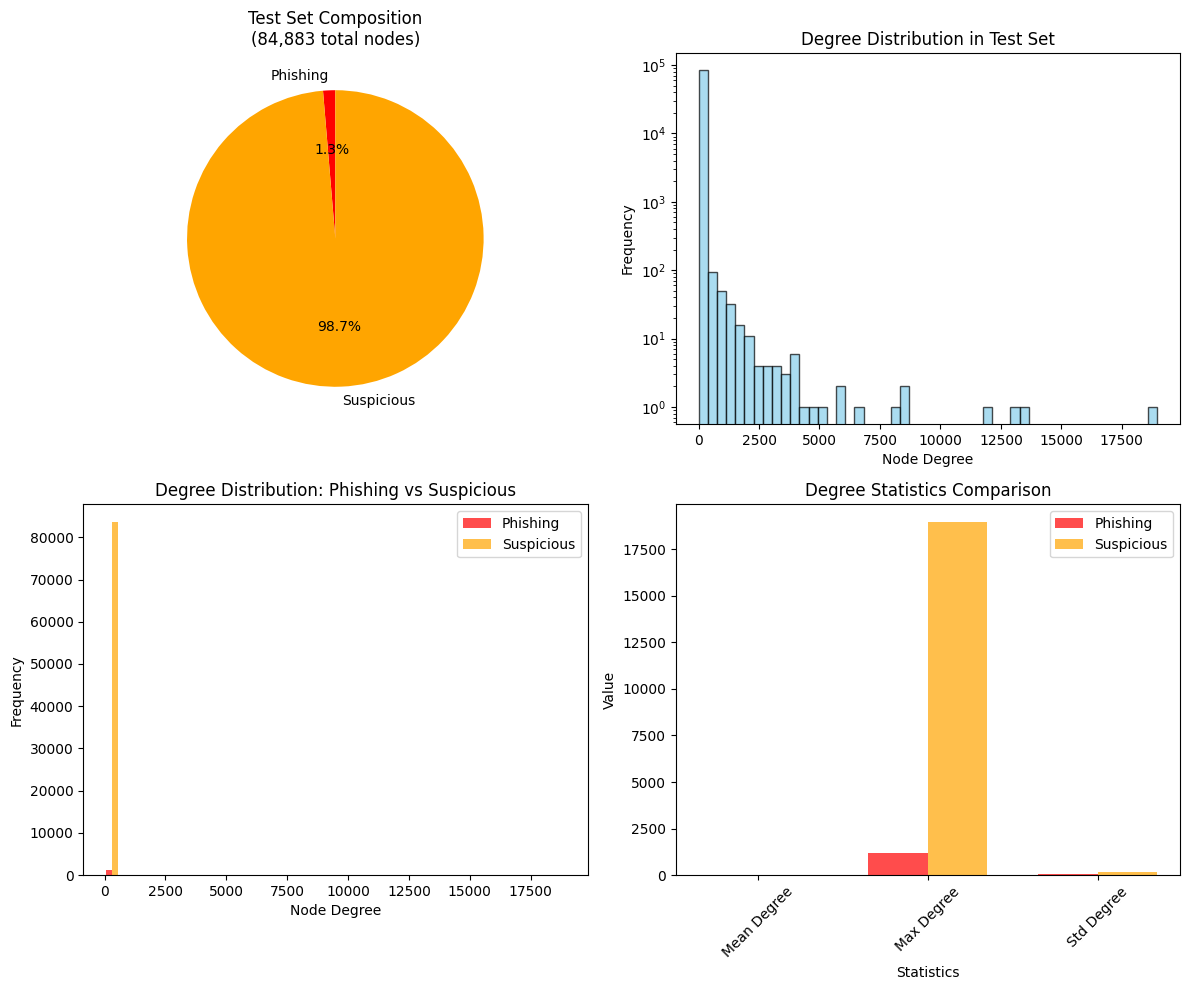


🎯 Test set ready for use:
   • test_nodes: List of 84,883 test nodes
   • test_subgraph: NetworkX graph with 351,329 edges
   • test_analysis: Dict with statistics and degree information
   • Files saved in Dataset/ and Dataset/Figures/


In [7]:
# Test Set Creation - Step 4
# This cell can be run independently after Step 1 and Step 3

import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

def load_data_for_test_set():
    """Load processed data for test set creation"""
    with open("Dataset/Processed/G.pkl", 'rb') as f:
        G = pickle.load(f)
    with open("Dataset/Processed/phishing_nodes.pkl", 'rb') as f:
        phishing_nodes = pickle.load(f)
    with open("Dataset/Processed/suspicious_nodes.pkl", 'rb') as f:
        suspicious_nodes = pickle.load(f)
    return G, phishing_nodes, suspicious_nodes

def create_or_load_test_set():
    """Create test set or load if already created"""
    
    # Check if test set exists
    test_files = [
        "Dataset/test_nodes.pkl",
        "Dataset/test_subgraph.pkl",
        "Dataset/Processed/test_analysis.pkl"
    ]
    
    if all(os.path.exists(f) for f in test_files):
        print("📂 Loading pre-created test set...")
        
        with open("Dataset/test_nodes.pkl", 'rb') as f:
            test_nodes = pickle.load(f)
        with open("Dataset/test_subgraph.pkl", 'rb') as f:
            test_subgraph = pickle.load(f)
        with open("Dataset/Processed/test_analysis.pkl", 'rb') as f:
            test_analysis = pickle.load(f)
        
        print(f"✅ Loaded test set: {len(test_nodes):,} nodes")
        return test_nodes, test_subgraph, test_analysis
    
    else:
        print("🔄 Creating new test set...")
        
        # Load data
        G, phishing_nodes, suspicious_nodes = load_data_for_test_set()
        
        # Create test set (phishing + suspicious nodes)
        test_nodes = set(phishing_nodes + suspicious_nodes)
        print(f"✅ Initial test set: {len(test_nodes):,} nodes")
        print(f"   • Phishing nodes: {len(phishing_nodes):,}")
        print(f"   • Suspicious nodes: {len(suspicious_nodes):,}")
        
        # Create test subgraph and remove isolated nodes
        print("🔄 Creating test subgraph and removing isolated nodes...")
        test_subgraph = G.subgraph(test_nodes).copy()
        test_isolated = list(nx.isolates(test_subgraph))
        test_nodes -= set(test_isolated)
        test_subgraph = G.subgraph(test_nodes).copy()
        
        print(f"✅ Test set after removing {len(test_isolated):,} isolated nodes: {len(test_nodes):,} nodes")
        
        # Analyze test set composition
        test_phishing_count = len([n for n in test_nodes if n in phishing_nodes])
        test_suspicious_count = len([n for n in test_nodes if n in suspicious_nodes])
        
        # Calculate degree statistics
        phishing_degrees = [test_subgraph.degree(node) for node in test_subgraph.nodes() 
                           if node in phishing_nodes]
        suspicious_degrees = [test_subgraph.degree(node) for node in test_subgraph.nodes() 
                             if node in suspicious_nodes]
        all_degrees = [test_subgraph.degree(node) for node in test_subgraph.nodes()]
        
        test_analysis = {
            'total_nodes': len(test_nodes),
            'phishing_count': test_phishing_count,
            'suspicious_count': test_suspicious_count,
            'total_edges': test_subgraph.number_of_edges(),
            'isolated_removed': len(test_isolated),
            'avg_degree': sum(all_degrees) / len(all_degrees),
            'phishing_degrees': phishing_degrees,
            'suspicious_degrees': suspicious_degrees,
            'all_degrees': all_degrees
        }
        
        print(f"\n📊 Test Set Analysis:")
        print(f"   • Final phishing nodes: {test_phishing_count:,}")
        print(f"   • Final suspicious nodes: {test_suspicious_count:,}")
        print(f"   • Test subgraph edges: {test_subgraph.number_of_edges():,}")
        print(f"   • Average degree: {test_analysis['avg_degree']:.2f}")
        
        # Save test set
        print("💾 Saving test set...")
        test_nodes_list = list(test_nodes)
        with open("Dataset/test_nodes.pkl", 'wb') as f:
            pickle.dump(test_nodes_list, f)
        with open("Dataset/test_subgraph.pkl", 'wb') as f:
            pickle.dump(test_subgraph, f)
        with open("Dataset/Processed/test_analysis.pkl", 'wb') as f:
            pickle.dump(test_analysis, f)
        
        print("✅ Test set saved!")
        return test_nodes_list, test_subgraph, test_analysis

# Create or load test set
test_nodes, test_subgraph, test_analysis = create_or_load_test_set()

# Create visualization
print("📊 Creating test set analysis visualization...")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Test set composition pie chart
composition_data = [test_analysis['phishing_count'], test_analysis['suspicious_count']]
composition_labels = ['Phishing', 'Suspicious']
colors = ['red', 'orange']

axes[0,0].pie(composition_data, labels=composition_labels, colors=colors, 
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title(f'Test Set Composition\n({test_analysis["total_nodes"]:,} total nodes)')

# Degree distribution
axes[0,1].hist(test_analysis['all_degrees'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_xlabel('Node Degree')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Degree Distribution in Test Set')
axes[0,1].set_yscale('log')

# Compare phishing vs suspicious degree distributions
axes[1,0].hist([test_analysis['phishing_degrees'], test_analysis['suspicious_degrees']], 
               bins=30, label=['Phishing', 'Suspicious'], color=['red', 'orange'], alpha=0.7)
axes[1,0].set_xlabel('Node Degree')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Degree Distribution: Phishing vs Suspicious')
axes[1,0].legend()

# Statistics comparison
stats_data = {
    'Mean Degree': [np.mean(test_analysis['phishing_degrees']), np.mean(test_analysis['suspicious_degrees'])],
    'Max Degree': [np.max(test_analysis['phishing_degrees']), np.max(test_analysis['suspicious_degrees'])],
    'Std Degree': [np.std(test_analysis['phishing_degrees']), np.std(test_analysis['suspicious_degrees'])]
}

x = np.arange(len(stats_data))
width = 0.35

for i, (stat_name, values) in enumerate(stats_data.items()):
    axes[1,1].bar(x[i] - width/2, values[0], width, label='Phishing' if i == 0 else "", color='red', alpha=0.7)
    axes[1,1].bar(x[i] + width/2, values[1], width, label='Suspicious' if i == 0 else "", color='orange', alpha=0.7)

axes[1,1].set_xlabel('Statistics')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Degree Statistics Comparison')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(stats_data.keys(), rotation=45)
axes[1,1].legend()

plt.tight_layout()
plt.savefig("Dataset/Figures/test_set_analysis.png", dpi=300, bbox_inches='tight')
print("📊 Test set analysis chart saved to: Dataset/Figures/test_set_analysis.png")
plt.show()

print(f"\n🎯 Test set ready for use:")
print(f"   • test_nodes: List of {len(test_nodes):,} test nodes")
print(f"   • test_subgraph: NetworkX graph with {test_subgraph.number_of_edges():,} edges")
print(f"   • test_analysis: Dict with statistics and degree information")
print(f"   • Files saved in Dataset/ and Dataset/Figures/")

### Network Visualization and Quick Data Access

📂 Loading data for visualization...
🎨 Creating network visualization...
🎨 Creating network visualization...
   All phishing nodes in test set: 1125
   All phishing nodes in test set: 1125
   Nearby suspicious nodes: 5157
   Nearby suspicious nodes: 5157
   Total nodes to visualize: 6282
   Generating layout...
   Total nodes to visualize: 6282
   Generating layout...

📊 Network Visualization Statistics:
   • All phishing nodes displayed: 1125
   • Nearby suspicious nodes displayed: 5157
   • Total edges shown: 83518

📊 Network Visualization Statistics:
   • All phishing nodes displayed: 1125
   • Nearby suspicious nodes displayed: 5157
   • Total edges shown: 83518
   • Connected components: 295
   • Phishing-to-suspicious connections: 4306
   • Average connections per phishing node: 3.83
   • Connected components: 295
   • Phishing-to-suspicious connections: 4306
   • Average connections per phishing node: 3.83
🎨 Phishing network visualization saved to: Dataset/Figures/phishing_networ

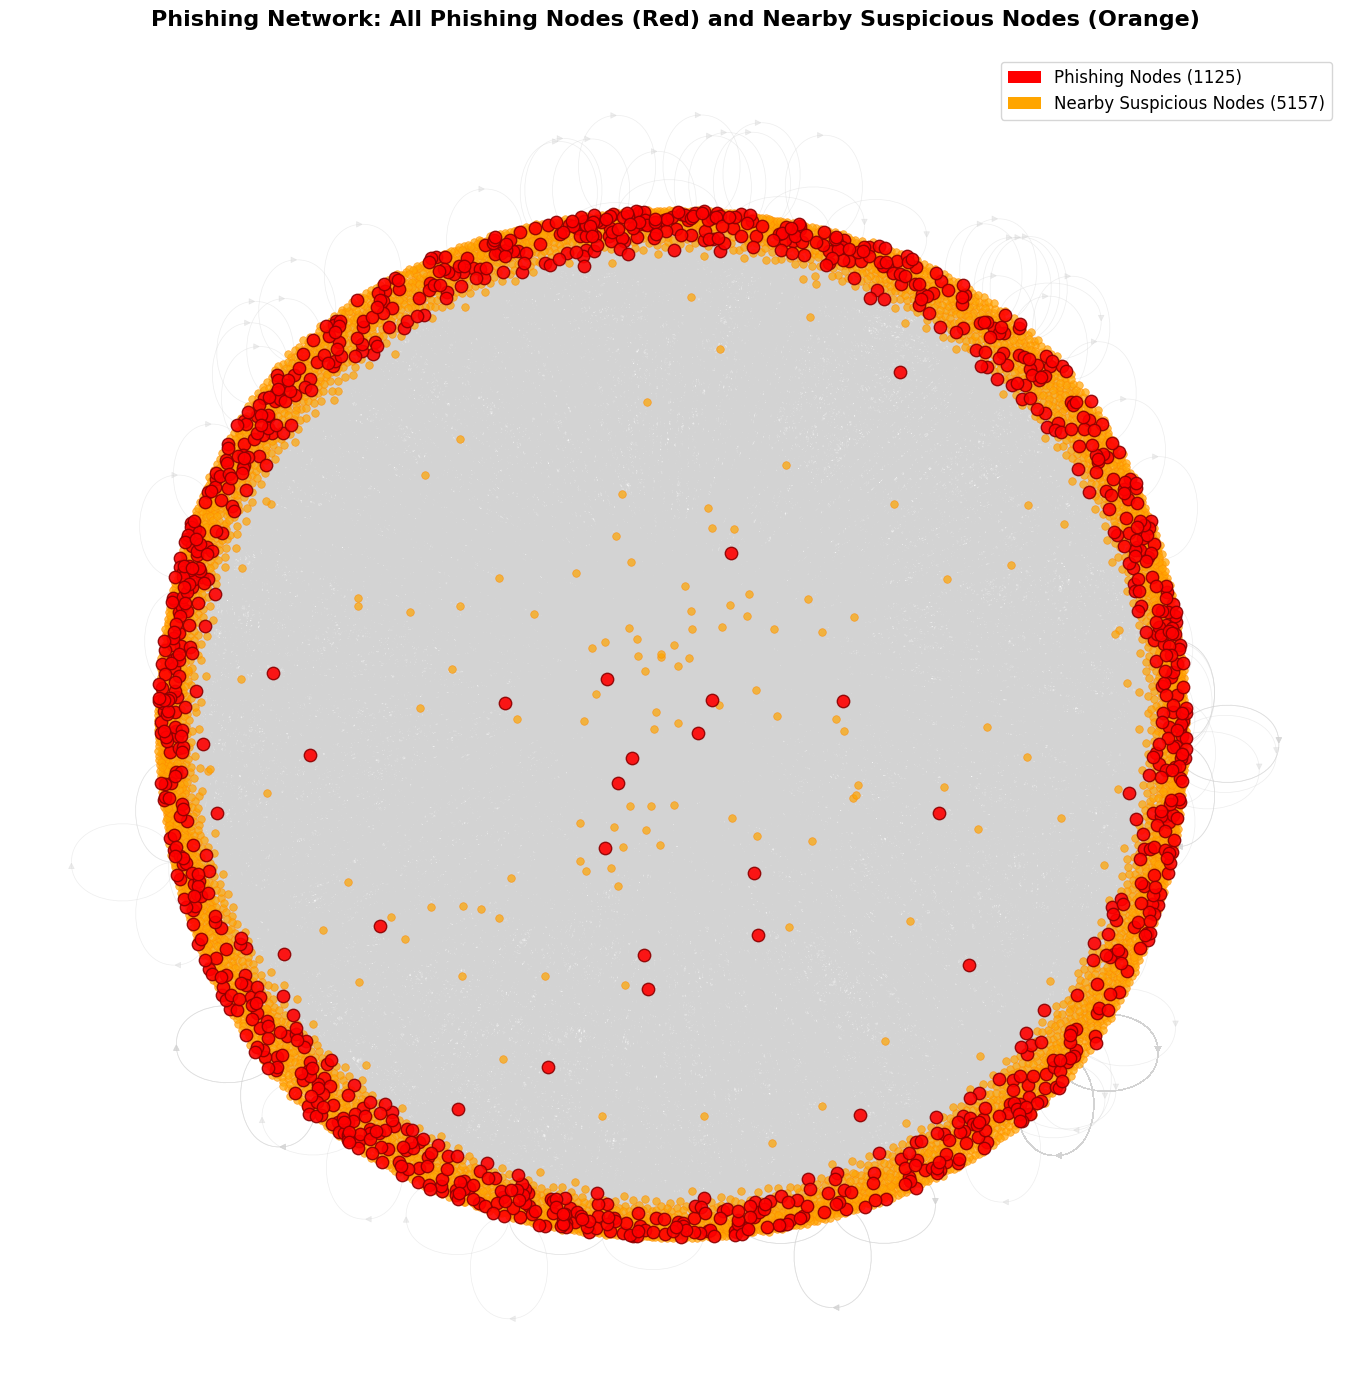


✅ Network visualization completed!


In [8]:
# Network Visualization - Step 5
# This cell can be run independently after Step 1, Step 3, and Step 4

import pickle
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

def load_data_for_visualization():
    """Load all required data for visualization"""
    with open("Dataset/Processed/phishing_nodes.pkl", 'rb') as f:
        phishing_nodes = pickle.load(f)
    with open("Dataset/Processed/suspicious_nodes.pkl", 'rb') as f:
        suspicious_nodes = pickle.load(f)
    with open("Dataset/test_nodes.pkl", 'rb') as f:
        test_nodes = pickle.load(f)
    with open("Dataset/test_subgraph.pkl", 'rb') as f:
        test_subgraph = pickle.load(f)
    
    return phishing_nodes, suspicious_nodes, test_nodes, test_subgraph

def create_network_visualization():
    """Create network visualization showing phishing and nearby suspicious nodes"""
    
    print("📂 Loading data for visualization...")
    phishing_nodes, suspicious_nodes, test_nodes, test_subgraph = load_data_for_visualization()
    
    print(f"🎨 Creating network visualization...")
    
    # Get all phishing nodes in test set
    all_phishing_in_test = [n for n in test_nodes if n in phishing_nodes]
    print(f"   All phishing nodes in test set: {len(all_phishing_in_test)}")
    
    # Find suspicious nodes that are connected to phishing nodes (within 2 hops)
    nearby_suspicious = set()
    for phishing_node in all_phishing_in_test:
        if phishing_node in test_subgraph:  # Check if node exists in subgraph
            # Get direct neighbors of phishing nodes
            neighbors = set(test_subgraph.neighbors(phishing_node))
            
            # Add suspicious neighbors
            suspicious_neighbors = [n for n in neighbors if n in suspicious_nodes]
            nearby_suspicious.update(suspicious_neighbors)
            
            # Get second-hop neighbors through suspicious nodes
            for suspicious_neighbor in suspicious_neighbors:
                if suspicious_neighbor in test_subgraph:
                    second_hop = set(test_subgraph.neighbors(suspicious_neighbor))
                    second_hop_suspicious = [n for n in second_hop if n in suspicious_nodes]
                    nearby_suspicious.update(second_hop_suspicious[:5])  # Limit to avoid overcrowding
    
    nearby_suspicious = list(nearby_suspicious)
    print(f"   Nearby suspicious nodes: {len(nearby_suspicious)}")
    
    # Create visualization nodes (all phishing + nearby suspicious)
    vis_nodes = all_phishing_in_test + nearby_suspicious
    
    # Filter nodes that actually exist in the test subgraph
    vis_nodes = [n for n in vis_nodes if n in test_subgraph]
    
    if not vis_nodes:
        print("⚠️ No nodes to visualize (no connections found)")
        return
    
    vis_subgraph = test_subgraph.subgraph(vis_nodes).copy()
    print(f"   Total nodes to visualize: {len(vis_nodes)}")
    
    # Create a large beautiful plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 14))
    
    # Use spring layout for natural clustering
    print("   Generating layout...")
    if len(vis_nodes) > 0:
        pos = nx.spring_layout(vis_subgraph, k=2, iterations=100, seed=42)
        
        # Draw edges first (background)
        nx.draw_networkx_edges(vis_subgraph, pos, 
                              edge_color='lightgray', 
                              alpha=0.4, 
                              width=0.5)
        
        # Draw suspicious nodes first (background layer)
        suspicious_nodes_in_vis = [n for n in vis_nodes if n in suspicious_nodes]
        if suspicious_nodes_in_vis:
            nx.draw_networkx_nodes(vis_subgraph, pos, 
                                  nodelist=suspicious_nodes_in_vis,
                                  node_color='orange',
                                  node_size=30,
                                  alpha=0.7,
                                  edgecolors='darkorange',
                                  linewidths=0.5)
        
        # Draw all phishing nodes on top
        phishing_nodes_in_vis = [n for n in vis_nodes if n in phishing_nodes]
        if phishing_nodes_in_vis:
            nx.draw_networkx_nodes(vis_subgraph, pos, 
                                  nodelist=phishing_nodes_in_vis,
                                  node_color='red',
                                  node_size=80,
                                  alpha=0.9,
                                  edgecolors='darkred',
                                  linewidths=1.0)
        
        # Add title
        ax.set_title('Phishing Network: All Phishing Nodes (Red) and Nearby Suspicious Nodes (Orange)', 
                     fontsize=16, fontweight='bold', pad=20)
        
        # Create legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', label=f'Phishing Nodes ({len(phishing_nodes_in_vis)})'),
            Patch(facecolor='orange', label=f'Nearby Suspicious Nodes ({len(suspicious_nodes_in_vis)})')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
        
        # Print statistics
        print(f"\n📊 Network Visualization Statistics:")
        print(f"   • All phishing nodes displayed: {len(phishing_nodes_in_vis)}")
        print(f"   • Nearby suspicious nodes displayed: {len(suspicious_nodes_in_vis)}")
        print(f"   • Total edges shown: {vis_subgraph.number_of_edges()}")
        if vis_subgraph.number_of_nodes() > 0:
            print(f"   • Connected components: {nx.number_connected_components(vis_subgraph.to_undirected())}")
        
        # Analyze connections
        phishing_connections = 0
        for phishing_node in phishing_nodes_in_vis:
            phishing_connections += len([n for n in vis_subgraph.neighbors(phishing_node) 
                                        if n in suspicious_nodes_in_vis])
        
        if len(phishing_nodes_in_vis) > 0:
            print(f"   • Phishing-to-suspicious connections: {phishing_connections}")
            print(f"   • Average connections per phishing node: {phishing_connections/len(phishing_nodes_in_vis):.2f}")
    
    # Clean styling
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.margins(0.05)
    
    plt.tight_layout()
    
    # Save the visualization
    plt.savefig("Dataset/Figures/phishing_network_visualization.png", dpi=300, bbox_inches='tight', 
               facecolor='white', edgecolor='none')
    print(f"🎨 Phishing network visualization saved to: Dataset/Figures/phishing_network_visualization.png")
    
    plt.show()
    
    print(f"\n✅ Network visualization completed!")

# Create the visualization
create_network_visualization()

### watch dataset status

In [9]:
# Quick Data Status Check and Loading - Run Anytime
# This cell shows what data is available and loads key variables

import pickle
import os
from datetime import datetime

def check_data_status():
    """Check what processed data files are available"""
    
    print("📋 Data Status Check")
    print("=" * 50)
    
    # Check raw data
    raw_files = ["Dataset_GAE/MulDiGraph.pkl"]
    
    # Check processed data
    processed_files = [
        "Dataset/Processed/G.pkl",
        "Dataset/Processed/phishing_nodes.pkl", 
        "Dataset/Processed/normal_nodes.pkl",
        "Dataset/Processed/suspicious_nodes.pkl",
        "Dataset/Processed/detection_results.pkl",
        "Dataset/Processed/test_analysis.pkl"
    ]
    
    # Check models
    model_files = [
        "Dataset/Models/gae_model.pth",
        "Dataset/Models/node_mapping.pkl",
        "Dataset/Models/sample_embeddings.pkl"
    ]
    
    # Check datasets
    dataset_files = [
        "Dataset/test_nodes.pkl",
        "Dataset/test_subgraph.pkl",
        "Dataset/training_nodes.pkl",
        "Dataset/training_subgraph.pkl"
    ]
    
    # Check figures
    figure_files = [
        "Dataset/Figures/suspicious_node_detection.png",
        "Dataset/Figures/test_set_analysis.png",
        "Dataset/Figures/phishing_network_visualization.png"
    ]
    
    def check_files(file_list, category_name):
        print(f"\n{category_name}:")
        all_exist = True
        for file in file_list:
            if os.path.exists(file):
                size = os.path.getsize(file) / (1024*1024)  # MB
                modified = datetime.fromtimestamp(os.path.getmtime(file)).strftime("%Y-%m-%d %H:%M")
                print(f"   ✅ {file} ({size:.1f} MB, modified: {modified})")
            else:
                print(f"   ❌ {file} (missing)")
                all_exist = False
        return all_exist
    
    raw_ok = check_files(raw_files, "Raw Data")
    processed_ok = check_files(processed_files, "Processed Data")
    models_ok = check_files(model_files, "Trained Models")
    datasets_ok = check_files(dataset_files, "Test Datasets")
    figures_ok = check_files(figure_files, "Generated Figures")
    
    print(f"\n📊 Summary:")
    print(f"   Raw Data: {'✅ Ready' if raw_ok else '❌ Missing'}")
    print(f"   Processed Data: {'✅ Ready' if processed_ok else '❌ Missing'}")
    print(f"   Trained Models: {'✅ Ready' if models_ok else '❌ Missing'}")
    print(f"   Test Datasets: {'✅ Ready' if datasets_ok else '❌ Missing'}")
    print(f"   Generated Figures: {'✅ Ready' if figures_ok else '❌ Missing'}")
    
    return {
        'raw': raw_ok,
        'processed': processed_ok, 
        'models': models_ok,
        'datasets': datasets_ok,
        'figures': figures_ok
    }

def quick_load_all_data():
    """Quick load all available processed data into variables"""
    
    print("\n🚀 Quick Loading All Available Data...")
    
    loaded_vars = {}
    
    try:
        # Load basic processed data
        if os.path.exists("Dataset/Processed/G.pkl"):
            with open("Dataset/Processed/G.pkl", 'rb') as f:
                G = pickle.load(f)
            loaded_vars['G'] = G
            print(f"   ✅ G: NetworkX graph ({G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges)")
        
        if os.path.exists("Dataset/Processed/phishing_nodes.pkl"):
            with open("Dataset/Processed/phishing_nodes.pkl", 'rb') as f:
                phishing_nodes = pickle.load(f)
            loaded_vars['phishing_nodes'] = phishing_nodes
            print(f"   ✅ phishing_nodes: List with {len(phishing_nodes):,} nodes")
        
        if os.path.exists("Dataset/Processed/suspicious_nodes.pkl"):
            with open("Dataset/Processed/suspicious_nodes.pkl", 'rb') as f:
                suspicious_nodes = pickle.load(f)
            loaded_vars['suspicious_nodes'] = suspicious_nodes
            print(f"   ✅ suspicious_nodes: List with {len(suspicious_nodes):,} nodes")
        
        if os.path.exists("Dataset/Processed/detection_results.pkl"):
            with open("Dataset/Processed/detection_results.pkl", 'rb') as f:
                detection_results = pickle.load(f)
            loaded_vars['detection_results'] = detection_results
            print(f"   ✅ detection_results: Dict with similarity scores and stats")
        
        # Load test data
        if os.path.exists("Dataset/test_nodes.pkl"):
            with open("Dataset/test_nodes.pkl", 'rb') as f:
                test_nodes = pickle.load(f)
            loaded_vars['test_nodes'] = test_nodes
            print(f"   ✅ test_nodes: List with {len(test_nodes):,} nodes")
        
        if os.path.exists("Dataset/test_subgraph.pkl"):
            with open("Dataset/test_subgraph.pkl", 'rb') as f:
                test_subgraph = pickle.load(f)
            loaded_vars['test_subgraph'] = test_subgraph
            print(f"   ✅ test_subgraph: NetworkX graph ({test_subgraph.number_of_nodes():,} nodes, {test_subgraph.number_of_edges():,} edges)")
        
        if os.path.exists("Dataset/Processed/test_analysis.pkl"):
            with open("Dataset/Processed/test_analysis.pkl", 'rb') as f:
                test_analysis = pickle.load(f)
            loaded_vars['test_analysis'] = test_analysis
            print(f"   ✅ test_analysis: Dict with test set statistics")
        
        # Load training data
        if os.path.exists("Dataset/training_nodes.pkl"):
            with open("Dataset/training_nodes.pkl", 'rb') as f:
                training_nodes = pickle.load(f)
            loaded_vars['training_nodes'] = training_nodes
            print(f"   ✅ training_nodes: List with {len(training_nodes):,} nodes")
        
        if os.path.exists("Dataset/training_subgraph.pkl"):
            with open("Dataset/training_subgraph.pkl", 'rb') as f:
                training_subgraph = pickle.load(f)
            loaded_vars['training_subgraph'] = training_subgraph
            print(f"   ✅ training_subgraph: NetworkX graph ({training_subgraph.number_of_nodes():,} nodes, {training_subgraph.number_of_edges():,} edges)")
        
        if os.path.exists("Dataset/Processed/training_analysis.pkl"):
            with open("Dataset/Processed/training_analysis.pkl", 'rb') as f:
                training_analysis = pickle.load(f)
            loaded_vars['training_analysis'] = training_analysis
            print(f"   ✅ training_analysis: Dict with training set statistics")
        
        print(f"\n✅ Successfully loaded {len(loaded_vars)} variables!")
        print(f"📝 Available variables: {', '.join(loaded_vars.keys())}")
        
        # Return all loaded variables to global scope
        return loaded_vars
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return {}

# Run status check
status = check_data_status()

# If processed data exists, load everything
if status['processed']:
    loaded_data = quick_load_all_data()
    # Make variables available globally
    for var_name, var_value in loaded_data.items():
        globals()[var_name] = var_value
    
    print(f"\n🎯 Ready to use! All variables are now available in this notebook.")
    
else:
    print(f"\n📌 Next Steps:")
    if not status['raw']:
        print(f"   1. Ensure Dataset/MulDiGraph.pkl exists")
    if not status['processed']:
        print(f"   2. Run Step 1 (Data Loading and Preprocessing)")
        print(f"   3. Run Step 3 (Suspicious Node Detection)")
    if not status['datasets']:
        print(f"   4. Run Step 4 (Test Set Creation)")
    if not status['figures']:
        print(f"   5. Run Step 5 (Network Visualization)")

📋 Data Status Check

Raw Data:
   ✅ Dataset_GAE/MulDiGraph.pkl (1199.3 MB, modified: 2025-06-15 00:41)

Processed Data:
   ✅ Dataset/Processed/G.pkl (1021.8 MB, modified: 2025-07-29 20:08)
   ✅ Dataset/Processed/phishing_nodes.pkl (0.1 MB, modified: 2025-07-29 20:08)
   ✅ Dataset/Processed/normal_nodes.pkl (127.6 MB, modified: 2025-07-29 20:08)
   ✅ Dataset/Processed/suspicious_nodes.pkl (6.4 MB, modified: 2025-07-29 20:10)
   ✅ Dataset/Processed/detection_results.pkl (9.1 MB, modified: 2025-07-29 20:10)
   ✅ Dataset/Processed/test_analysis.pkl (0.3 MB, modified: 2025-07-29 20:13)

Trained Models:
   ✅ Dataset/Models/gae_model.pth (0.0 MB, modified: 2025-07-29 20:09)
   ✅ Dataset/Models/node_mapping.pkl (1.7 MB, modified: 2025-07-29 20:09)
   ✅ Dataset/Models/sample_embeddings.pkl (1.1 MB, modified: 2025-07-29 20:09)

Test Datasets:
   ✅ Dataset/test_nodes.pkl (3.6 MB, modified: 2025-07-29 20:13)
   ✅ Dataset/test_subgraph.pkl (25.0 MB, modified: 2025-07-29 20:13)
   ❌ Dataset/training

## Step 6: Training Set Creation
Creates a clean training dataset by excluding all test nodes, phishing nodes, and suspicious nodes.

In [ ]:
# Training Set Creation - Step 6
# Creates a clean training dataset by excluding test nodes, phishing nodes, and suspicious nodes
# This cell can be run independently after previous steps

import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from collections import Counter

def load_data_for_training_set():
    """Load all necessary data for training set creation"""
    print("📂 Loading data for training set creation...")
    
    # Load main graph and node classifications
    with open("Dataset/Processed/G.pkl", 'rb') as f:
        G = pickle.load(f)
    with open("Dataset/Processed/phishing_nodes.pkl", 'rb') as f:
        phishing_nodes = pickle.load(f)
    with open("Dataset/Processed/normal_nodes.pkl", 'rb') as f:
        normal_nodes = pickle.load(f)
    with open("Dataset/Processed/suspicious_nodes.pkl", 'rb') as f:
        suspicious_nodes = pickle.load(f)
    with open("Dataset/test_nodes.pkl", 'rb') as f:
        test_nodes = pickle.load(f)
    
    print(f"✅ Data loaded:")
    print(f"   • Total graph nodes: {G.number_of_nodes():,}")
    print(f"   • Phishing nodes: {len(phishing_nodes):,}")
    print(f"   • Normal nodes: {len(normal_nodes):,}")
    print(f"   • Suspicious nodes: {len(suspicious_nodes):,}")
    print(f"   • Test nodes: {len(test_nodes):,}")
    
    return G, phishing_nodes, normal_nodes, suspicious_nodes, test_nodes

def create_or_load_training_set():
    """Create training set or load if already created"""
    
    # Check if training set already exists
    training_files = [
        "Dataset/training_nodes.pkl",
        "Dataset/training_subgraph.pkl",
        "Dataset/Processed/training_analysis.pkl"
    ]
    
    if all(os.path.exists(f) for f in training_files):
        print("📂 Loading pre-created training set...")
        
        with open("Dataset/training_nodes.pkl", 'rb') as f:
            training_nodes = pickle.load(f)
        with open("Dataset/training_subgraph.pkl", 'rb') as f:
            training_subgraph = pickle.load(f)
        with open("Dataset/Processed/training_analysis.pkl", 'rb') as f:
            training_analysis = pickle.load(f)
        
        print(f"✅ Loaded training set: {len(training_nodes):,} nodes")
        return training_nodes, training_subgraph, training_analysis
    
    else:
        print("🔄 Creating new training set...")
        
        # Load all data
        G, phishing_nodes, normal_nodes, suspicious_nodes, test_nodes = load_data_for_training_set()
        
        # Create exclusion set (all nodes that should NOT be in training set)
        print("🚫 Creating exclusion list...")
        exclusion_set = set()
        
        # Add phishing nodes
        exclusion_set.update(phishing_nodes)
        print(f"   • Excluded phishing nodes: {len(phishing_nodes):,}")
        
        # Add suspicious nodes
        exclusion_set.update(suspicious_nodes)
        print(f"   • Excluded suspicious nodes: {len(suspicious_nodes):,}")
        
        # Add test nodes
        exclusion_set.update(test_nodes)
        print(f"   • Excluded test nodes: {len(test_nodes):,}")
        
        # Calculate total unique exclusions
        total_excluded = len(exclusion_set)
        print(f"   • Total unique excluded nodes: {total_excluded:,}")
        
        # Create training set from remaining nodes
        print("✅ Creating training set from remaining nodes...")
        all_nodes = set(G.nodes())
        training_nodes_set = all_nodes - exclusion_set
        
        print(f"   • Nodes available for training: {len(training_nodes_set):,}")
        print(f"   • Percentage of total graph: {len(training_nodes_set)/len(all_nodes)*100:.1f}%")
        
        # Convert to list and create subgraph
        training_nodes = list(training_nodes_set)
        print(f"🔄 Creating training subgraph...")
        training_subgraph = G.subgraph(training_nodes).copy()
        
        # Remove isolated nodes to improve training quality
        print(f"🧹 Removing isolated nodes...")
        isolated_nodes = list(nx.isolates(training_subgraph))
        if isolated_nodes:
            training_nodes_set -= set(isolated_nodes)
            training_nodes = list(training_nodes_set)
            training_subgraph = G.subgraph(training_nodes).copy()
            print(f"   • Removed {len(isolated_nodes):,} isolated nodes")
        
        print(f"✅ Final training set:")
        print(f"   • Training nodes: {len(training_nodes):,}")
        print(f"   • Training edges: {training_subgraph.number_of_edges():,}")
        print(f"   • Connected components: {nx.number_connected_components(training_subgraph.to_undirected())}")
        
        # Analyze training set characteristics
        print(f"📊 Analyzing training set characteristics...")
        
        # Calculate degree statistics
        degrees = [training_subgraph.degree(node) for node in training_nodes]
        in_degrees = [training_subgraph.in_degree(node) for node in training_nodes]
        out_degrees = [training_subgraph.out_degree(node) for node in training_nodes]
        
        # Node type analysis (should all be normal since we excluded phishing/suspicious)
        node_types_in_training = []
        for node in training_nodes:
            if node in phishing_nodes:
                node_types_in_training.append('phishing')  # Should be 0
            elif node in suspicious_nodes:
                node_types_in_training.append('suspicious')  # Should be 0
            else:
                node_types_in_training.append('normal')
        
        type_counts = Counter(node_types_in_training)
        
        # Create training analysis
        training_analysis = {
            'total_nodes': len(training_nodes),
            'total_edges': training_subgraph.number_of_edges(),
            'excluded_phishing': len([n for n in phishing_nodes if n in all_nodes]),
            'excluded_suspicious': len([n for n in suspicious_nodes if n in all_nodes]),
            'excluded_test': len([n for n in test_nodes if n in all_nodes]),
            'total_excluded': total_excluded,
            'isolated_removed': len(isolated_nodes),
            'connected_components': nx.number_connected_components(training_subgraph.to_undirected()),
            'node_type_counts': dict(type_counts),
            'degree_stats': {
                'mean': np.mean(degrees),
                'std': np.std(degrees),
                'min': np.min(degrees),
                'max': np.max(degrees),
                'median': np.median(degrees)
            },
            'in_degree_stats': {
                'mean': np.mean(in_degrees),
                'std': np.std(in_degrees),
                'min': np.min(in_degrees),
                'max': np.max(in_degrees),
                'median': np.median(in_degrees)
            },
            'out_degree_stats': {
                'mean': np.mean(out_degrees),
                'std': np.std(out_degrees),
                'min': np.min(out_degrees),
                'max': np.max(out_degrees),
                'median': np.median(out_degrees)
            },
            'degrees': degrees,
            'in_degrees': in_degrees,
            'out_degrees': out_degrees
        }
        
        print(f"\n📋 Training Set Verification:")
        print(f"   • Normal nodes: {type_counts.get('normal', 0):,}")
        print(f"   • Phishing nodes: {type_counts.get('phishing', 0):,} (should be 0)")
        print(f"   • Suspicious nodes: {type_counts.get('suspicious', 0):,} (should be 0)")
        print(f"   • Average degree: {training_analysis['degree_stats']['mean']:.2f}")
        print(f"   • Degree range: {training_analysis['degree_stats']['min']} - {training_analysis['degree_stats']['max']}")
        
        # Verify no contamination
        contamination_check = {
            'phishing_in_training': len(set(training_nodes) & set(phishing_nodes)),
            'suspicious_in_training': len(set(training_nodes) & set(suspicious_nodes)),
            'test_in_training': len(set(training_nodes) & set(test_nodes))
        }
        
        print(f"\n🔍 Contamination Check:")
        print(f"   • Phishing nodes in training: {contamination_check['phishing_in_training']} (should be 0)")
        print(f"   • Suspicious nodes in training: {contamination_check['suspicious_in_training']} (should be 0)")
        print(f"   • Test nodes in training: {contamination_check['test_in_training']} (should be 0)")
        
        if all(count == 0 for count in contamination_check.values()):
            print("   ✅ Training set is clean - no contamination detected!")
        else:
            print("   ⚠️ WARNING: Contamination detected in training set!")
        
        # Save training set
        print(f"💾 Saving training set...")
        
        with open("Dataset/training_nodes.pkl", 'wb') as f:
            pickle.dump(training_nodes, f)
        print(f"   • Saved training nodes: {os.path.getsize('Dataset/training_nodes.pkl') / (1024*1024):.1f} MB")
        
        with open("Dataset/training_subgraph.pkl", 'wb') as f:
            pickle.dump(training_subgraph, f)
        print(f"   • Saved training subgraph: {os.path.getsize('Dataset/training_subgraph.pkl') / (1024*1024):.1f} MB")
        
        with open("Dataset/Processed/training_analysis.pkl", 'wb') as f:
            pickle.dump(training_analysis, f)
        print(f"   • Saved training analysis: {os.path.getsize('Dataset/Processed/training_analysis.pkl') / (1024*1024):.1f} MB")
        
        print("✅ Training set saved successfully!")
        return training_nodes, training_subgraph, training_analysis

# Create or load training set
training_nodes, training_subgraph, training_analysis = create_or_load_training_set()

# Create visualization of training set characteristics
print(f"\n📊 Creating training set visualization...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Data split overview
categories = ['Training', 'Test', 'Excluded\n(Phishing+Suspicious)']
sizes = [
    training_analysis['total_nodes'],
    len(test_nodes),
    training_analysis['excluded_phishing'] + training_analysis['excluded_suspicious']
]
colors = ['green', 'blue', 'red']

axes[0,0].pie(sizes, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Dataset Split Overview')

# 2. Degree distribution
axes[0,1].hist(training_analysis['degrees'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,1].set_xlabel('Node Degree')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Training Set Degree Distribution')
axes[0,1].set_yscale('log')

# 3. In-degree vs Out-degree
axes[1,0].scatter(training_analysis['in_degrees'][:1000], training_analysis['out_degrees'][:1000], 
                 alpha=0.5, s=10, color='green')
axes[1,0].set_xlabel('In-Degree')
axes[1,0].set_ylabel('Out-Degree')
axes[1,0].set_title('In-Degree vs Out-Degree (Sample of 1000 nodes)')
axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')

# 4. Statistics summary
stats_names = ['Mean Degree', 'Median Degree', 'Max Degree', 'Connected Components']
stats_values = [
    training_analysis['degree_stats']['mean'],
    training_analysis['degree_stats']['median'],
    training_analysis['degree_stats']['max'],
    training_analysis['connected_components']
]

bars = axes[1,1].bar(range(len(stats_names)), stats_values, color='green', alpha=0.7)
axes[1,1].set_xticks(range(len(stats_names)))
axes[1,1].set_xticklabels(stats_names, rotation=45, ha='right')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Training Set Statistics')
axes[1,1].set_yscale('log')

# Add value labels on bars
for bar, value in zip(bars, stats_values):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{value:.1f}' if value < 1000 else f'{value:.0f}',
                   ha='center', va='bottom')

plt.tight_layout()
plt.savefig("Dataset/Figures/training_set_analysis.png", dpi=300, bbox_inches='tight')
print(f"📊 Training set visualization saved to: Dataset/Figures/training_set_analysis.png")
plt.show()

print(f"\n🎯 Training set ready for use:")
print(f"   • training_nodes: List of {len(training_nodes):,} clean training nodes")
print(f"   • training_subgraph: NetworkX graph with {training_subgraph.number_of_edges():,} edges")
print(f"   • training_analysis: Dict with comprehensive statistics and analysis")
print(f"   • Files saved in Dataset/ and Dataset/Processed/")
print(f"\n✅ Training set creation completed successfully!")

🔄 Creating new training set...
📂 Loading data for training set creation...
✅ Data loaded:
   • Total graph nodes: 2,973,489
   • Phishing nodes: 1,165
   • Normal nodes: 2,972,324
   • Suspicious nodes: 148,616
   • Test nodes: 84,883
🚫 Creating exclusion list...
   • Excluded phishing nodes: 1,165
   • Excluded suspicious nodes: 148,616
   • Excluded test nodes: 84,883
   • Total unique excluded nodes: 149,781
✅ Creating training set from remaining nodes...
✅ Data loaded:
   • Total graph nodes: 2,973,489
   • Phishing nodes: 1,165
   • Normal nodes: 2,972,324
   • Suspicious nodes: 148,616
   • Test nodes: 84,883
🚫 Creating exclusion list...
   • Excluded phishing nodes: 1,165
   • Excluded suspicious nodes: 148,616
   • Excluded test nodes: 84,883
   • Total unique excluded nodes: 149,781
✅ Creating training set from remaining nodes...
   • Nodes available for training: 2,823,708
   • Percentage of total graph: 95.0%
🔄 Creating training subgraph...
   • Nodes available for training:

## Step 7: Training Subset Creation  
Splits the large training set into 3 manageable subsets, removes isolated nodes, and visualizes node types.

📂 Loading pre-created training subsets...
   • Subset 1: 309,292 nodes
   • Subset 1: 309,292 nodes
   • Subset 2: 283,092 nodes
   • Subset 2: 283,092 nodes
   • Subset 3: 292,167 nodes
✅ Training subsets loaded successfully!

📊 Creating training subsets visualization...
   • Subset 3: 292,167 nodes
✅ Training subsets loaded successfully!

📊 Creating training subsets visualization...
📊 Training subsets visualization saved to: Dataset/Figures/training_subsets_analysis.png
📊 Training subsets visualization saved to: Dataset/Figures/training_subsets_analysis.png


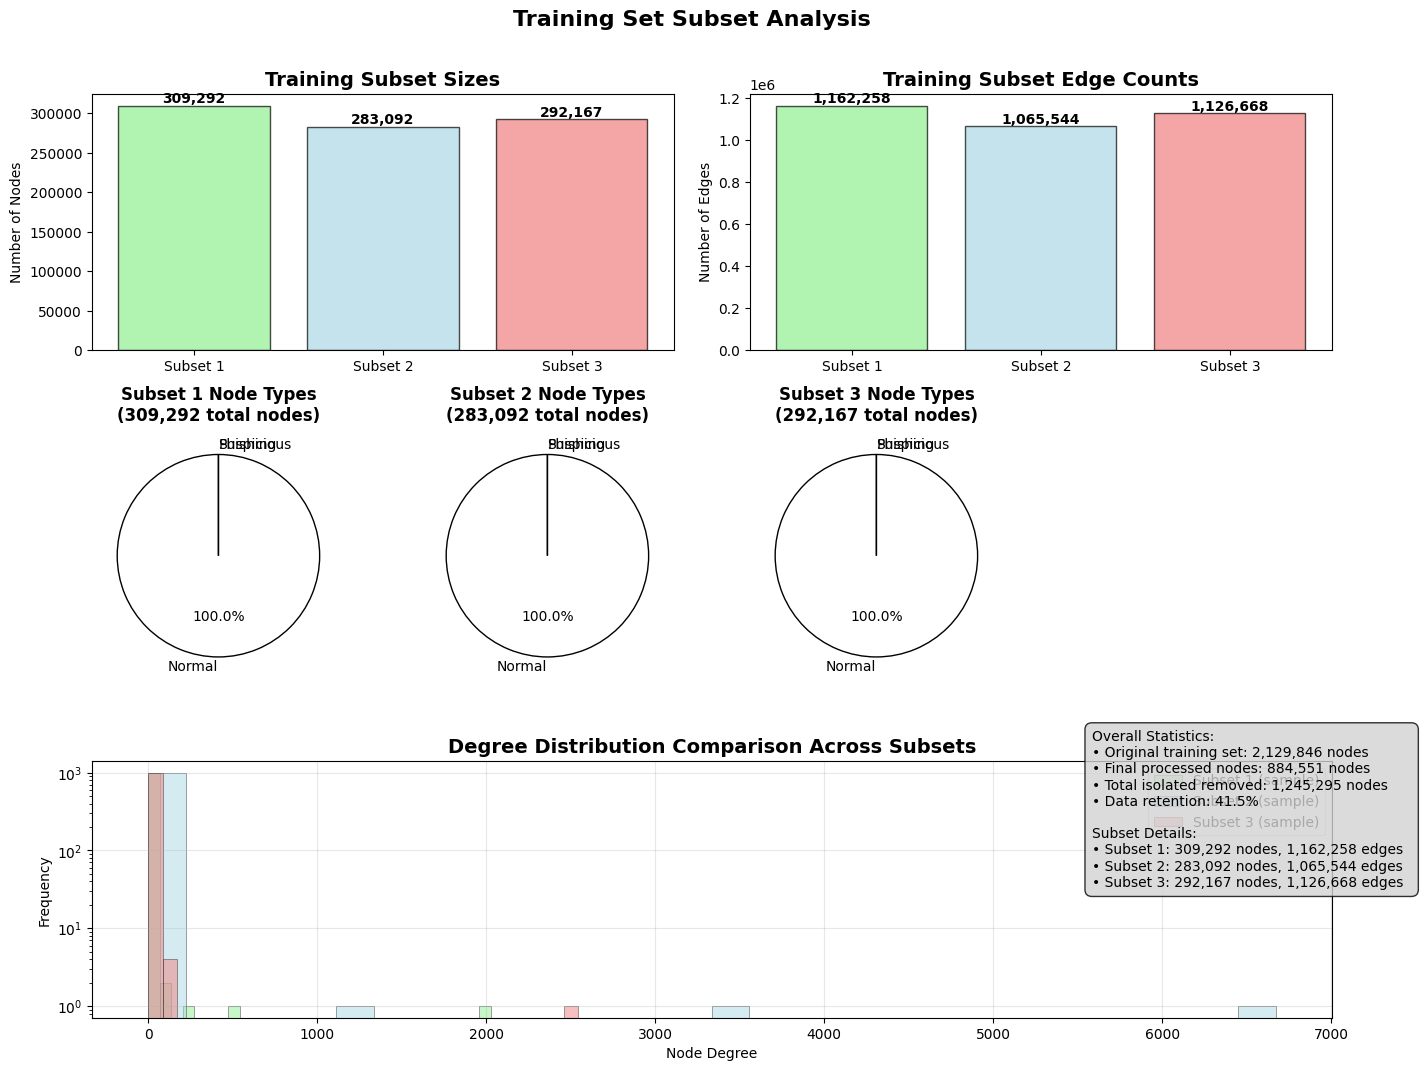


🎯 Training subsets ready for use:
   • training_subsets: Dict with 3 subsets containing nodes, subgraphs, and analysis
   • subsets_analysis: Dict with overall statistics and contamination checks
   • Files saved in Dataset/ and Dataset/Processed/

✅ Training subset creation completed successfully!

📋 Final Verification Summary:
   • Subset 1: 309,292 nodes, 1,162,258 edges, 399 components
     Node types: 309,292 normal, 0 phishing, 0 suspicious
   • Subset 2: 283,092 nodes, 1,065,544 edges, 367 components
     Node types: 283,092 normal, 0 phishing, 0 suspicious
   • Subset 3: 292,167 nodes, 1,126,668 edges, 311 components
     Node types: 292,167 normal, 0 phishing, 0 suspicious


In [ ]:
# Training Subset Creation - Step 7
# Splits the large training set into 3 manageable subsets and visualizes node types
# This cell can be run independently after Step 6

import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import random
from collections import Counter

def load_data_for_subset_creation():
    """Load training data and classification lists"""
    print("📂 Loading data for training subset creation...")
    
    # Load training data
    with open("Dataset/training_nodes.pkl", 'rb') as f:
        training_nodes = pickle.load(f)
    with open("Dataset/training_subgraph.pkl", 'rb') as f:
        training_subgraph = pickle.load(f)
    
    # Load classification data for verification
    with open("Dataset/Processed/phishing_nodes.pkl", 'rb') as f:
        phishing_nodes = pickle.load(f)
    with open("Dataset/Processed/suspicious_nodes.pkl", 'rb') as f:
        suspicious_nodes = pickle.load(f)
    
    print(f"✅ Data loaded:")
    print(f"   • Training nodes: {len(training_nodes):,}")
    print(f"   • Training edges: {training_subgraph.number_of_edges():,}")
    print(f"   • Phishing reference: {len(phishing_nodes):,}")
    print(f"   • Suspicious reference: {len(suspicious_nodes):,}")
    
    return training_nodes, training_subgraph, phishing_nodes, suspicious_nodes

def create_or_load_training_subsets():
    """Create training subsets or load if already created"""
    
    # Check if subsets already exist
    subset_files = [
        "Dataset/training_subset_1.pkl",
        "Dataset/training_subset_2.pkl", 
        "Dataset/training_subset_3.pkl",
        "Dataset/Processed/training_subsets_analysis.pkl"
    ]
    
    if all(os.path.exists(f) for f in subset_files):
        print("📂 Loading pre-created training subsets...")
        
        subsets = {}
        for i in range(1, 4):
            with open(f"Dataset/training_subset_{i}.pkl", 'rb') as f:
                subsets[f'subset_{i}'] = pickle.load(f)
            print(f"   • Subset {i}: {subsets[f'subset_{i}']['nodes_count']:,} nodes")
        
        with open("Dataset/Processed/training_subsets_analysis.pkl", 'rb') as f:
            analysis = pickle.load(f)
        
        print("✅ Training subsets loaded successfully!")
        return subsets, analysis
    
    else:
        print("🔄 Creating training subsets...")
        
        # Load data
        training_nodes, training_subgraph, phishing_nodes, suspicious_nodes = load_data_for_subset_creation()
        
        # Shuffle nodes for random distribution
        shuffled_nodes = training_nodes.copy()
        random.seed(42)  # For reproducibility
        random.shuffle(shuffled_nodes)
        
        # Split into 3 roughly equal parts
        total_nodes = len(shuffled_nodes)
        subset_size = total_nodes // 3
        
        print(f"📊 Splitting {total_nodes:,} nodes into 3 subsets...")
        print(f"   • Target subset size: ~{subset_size:,} nodes each")
        
        # Create node splits
        subset_1_nodes = shuffled_nodes[:subset_size]
        subset_2_nodes = shuffled_nodes[subset_size:2*subset_size]
        subset_3_nodes = shuffled_nodes[2*subset_size:]  # Remainder goes to subset 3
        
        print(f"✅ Initial splits:")
        print(f"   • Subset 1: {len(subset_1_nodes):,} nodes")
        print(f"   • Subset 2: {len(subset_2_nodes):,} nodes") 
        print(f"   • Subset 3: {len(subset_3_nodes):,} nodes")
        
        # Process each subset
        subsets = {}
        
        for i, nodes_list in enumerate([subset_1_nodes, subset_2_nodes, subset_3_nodes], 1):
            print(f"\n🔄 Processing Subset {i}...")
            
            # Create subgraph
            subset_subgraph = training_subgraph.subgraph(nodes_list).copy()
            
            # Remove isolated nodes
            isolated_nodes = list(nx.isolates(subset_subgraph))
            if isolated_nodes:
                print(f"   • Removing {len(isolated_nodes):,} isolated nodes...")
                nodes_list = [n for n in nodes_list if n not in isolated_nodes]
                subset_subgraph = training_subgraph.subgraph(nodes_list).copy()
            
            # Analyze node types (should all be normal, but let's verify)
            node_type_counts = {'normal': 0, 'phishing': 0, 'suspicious': 0}
            node_types = {}
            
            for node in nodes_list:
                if node in phishing_nodes:
                    node_types[node] = 'phishing'
                    node_type_counts['phishing'] += 1
                elif node in suspicious_nodes:
                    node_types[node] = 'suspicious'
                    node_type_counts['suspicious'] += 1
                else:
                    node_types[node] = 'normal'
                    node_type_counts['normal'] += 1
            
            # Calculate statistics
            degrees = [subset_subgraph.degree(node) for node in nodes_list]
            connected_components = nx.number_connected_components(subset_subgraph.to_undirected())
            
            subset_data = {
                'nodes': nodes_list,
                'subgraph': subset_subgraph,
                'node_types': node_types,
                'node_type_counts': node_type_counts,
                'nodes_count': len(nodes_list),
                'edges_count': subset_subgraph.number_of_edges(),
                'isolated_removed': len(isolated_nodes),
                'connected_components': connected_components,
                'degree_stats': {
                    'mean': np.mean(degrees) if degrees else 0,
                    'std': np.std(degrees) if degrees else 0,
                    'min': np.min(degrees) if degrees else 0,
                    'max': np.max(degrees) if degrees else 0,
                    'median': np.median(degrees) if degrees else 0
                },
                'degrees': degrees
            }
            
            subsets[f'subset_{i}'] = subset_data
            
            print(f"   ✅ Subset {i} processed:")
            print(f"      • Final nodes: {len(nodes_list):,}")
            print(f"      • Edges: {subset_subgraph.number_of_edges():,}")
            print(f"      • Connected components: {connected_components}")
            print(f"      • Node types: Normal={node_type_counts['normal']:,}, "
                  f"Phishing={node_type_counts['phishing']}, "
                  f"Suspicious={node_type_counts['suspicious']}")
            print(f"      • Average degree: {subset_data['degree_stats']['mean']:.2f}")
        
        # Create overall analysis
        total_final_nodes = sum(len(subsets[f'subset_{i}']['nodes']) for i in range(1, 4))
        total_final_edges = sum(subsets[f'subset_{i}']['edges_count'] for i in range(1, 4))
        total_isolated_removed = sum(subsets[f'subset_{i}']['isolated_removed'] for i in range(1, 4))
        
        analysis = {
            'original_training_size': total_nodes,
            'total_final_nodes': total_final_nodes,
            'total_final_edges': total_final_edges,
            'total_isolated_removed': total_isolated_removed,
            'subset_sizes': [len(subsets[f'subset_{i}']['nodes']) for i in range(1, 4)],
            'subset_edge_counts': [subsets[f'subset_{i}']['edges_count'] for i in range(1, 4)],
            'contamination_check': {
                f'subset_{i}': {
                    'phishing': subsets[f'subset_{i}']['node_type_counts']['phishing'],
                    'suspicious': subsets[f'subset_{i}']['node_type_counts']['suspicious']
                } for i in range(1, 4)
            }
        }
        
        print(f"\n📋 Overall Summary:")
        print(f"   • Original training nodes: {total_nodes:,}")
        print(f"   • Final nodes after processing: {total_final_nodes:,}")
        print(f"   • Total isolated nodes removed: {total_isolated_removed:,}")
        print(f"   • Data loss: {((total_nodes - total_final_nodes) / total_nodes * 100):.1f}%")
        
        # Contamination check
        total_contamination = sum(
            analysis['contamination_check'][f'subset_{i}']['phishing'] + 
            analysis['contamination_check'][f'subset_{i}']['suspicious']
            for i in range(1, 4)
        )
        
        if total_contamination == 0:
            print("   ✅ All subsets are clean - no contamination detected!")
        else:
            print(f"   ⚠️ WARNING: {total_contamination} contaminated nodes found!")
        
        # Save subsets
        print(f"\n💾 Saving training subsets...")
        
        for i in range(1, 4):
            # Save only essential data to reduce file size
            subset_to_save = {
                'nodes': subsets[f'subset_{i}']['nodes'],
                'subgraph': subsets[f'subset_{i}']['subgraph'],
                'node_types': subsets[f'subset_{i}']['node_types'],
                'node_type_counts': subsets[f'subset_{i}']['node_type_counts'],
                'nodes_count': subsets[f'subset_{i}']['nodes_count'],
                'edges_count': subsets[f'subset_{i}']['edges_count'],
                'connected_components': subsets[f'subset_{i}']['connected_components'],
                'degree_stats': subsets[f'subset_{i}']['degree_stats']
            }
            
            with open(f"Dataset/training_subset_{i}.pkl", 'wb') as f:
                pickle.dump(subset_to_save, f)
            
            file_size = os.path.getsize(f"Dataset/training_subset_{i}.pkl") / (1024*1024)
            print(f"   • Saved subset {i}: {file_size:.1f} MB")
        
        with open("Dataset/Processed/training_subsets_analysis.pkl", 'wb') as f:
            pickle.dump(analysis, f)
        
        analysis_size = os.path.getsize("Dataset/Processed/training_subsets_analysis.pkl") / (1024*1024)
        print(f"   • Saved analysis: {analysis_size:.1f} MB")
        
        print("✅ Training subsets saved successfully!")
        return subsets, analysis

# Create or load training subsets
training_subsets, subsets_analysis = create_or_load_training_subsets()

# Create comprehensive visualization
print(f"\n📊 Creating training subsets visualization...")
fig = plt.figure(figsize=(16, 12))

# Create a grid layout: 2 rows, 4 columns
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Top row: Subset size comparison
ax1 = fig.add_subplot(gs[0, :2])
subset_names = ['Subset 1', 'Subset 2', 'Subset 3']
subset_sizes = [training_subsets[f'subset_{i}']['nodes_count'] for i in range(1, 4)]
subset_colors = ['lightgreen', 'lightblue', 'lightcoral']

bars = ax1.bar(subset_names, subset_sizes, color=subset_colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Nodes')
ax1.set_title('Training Subset Sizes', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, size in zip(bars, subset_sizes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{size:,}', ha='center', va='bottom', fontweight='bold')

# Edge counts comparison
ax2 = fig.add_subplot(gs[0, 2:])
edge_counts = [training_subsets[f'subset_{i}']['edges_count'] for i in range(1, 4)]

bars2 = ax2.bar(subset_names, edge_counts, color=subset_colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Number of Edges')
ax2.set_title('Training Subset Edge Counts', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, count in zip(bars2, edge_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Second row: Node type verification for each subset
for i in range(1, 4):
    ax = fig.add_subplot(gs[1, i-1])
    
    node_counts = training_subsets[f'subset_{i}']['node_type_counts']
    types = ['Normal', 'Phishing', 'Suspicious']
    counts = [node_counts['normal'], node_counts['phishing'], node_counts['suspicious']]
    colors = ['white', 'red', 'yellow']
    
    # Create pie chart
    try:
        # Try new matplotlib version parameter name
        wedges, texts, autotexts = ax.pie(counts, labels=types, colors=colors, 
                                         autopct=lambda pct: f'{pct:.1f}%' if pct > 0 else '',
                                         startangle=90, wedgeprops={'edgecolor': 'black'})
    except TypeError:
        # Fallback for older matplotlib versions
        wedges, texts, autotexts = ax.pie(counts, labels=types, colors=colors, 
                                         autopct=lambda pct: f'{pct:.1f}%' if pct > 0 else '',
                                         startangle=90)
    
    ax.set_title(f'Subset {i} Node Types\n({node_counts["normal"]:,} total nodes)', 
                fontsize=12, fontweight='bold')
    
    # Add contamination warning if needed
    contamination = node_counts['phishing'] + node_counts['suspicious']
    if contamination > 0:
        ax.text(0, -1.3, f'⚠️ {contamination} contaminated nodes!', 
               ha='center', va='center', color='red', fontweight='bold')

# Third row: Degree distribution comparison
ax4 = fig.add_subplot(gs[2, :])

for i in range(1, 4):
    # Check if degrees data is available (might not be saved to reduce file size)
    if 'degrees' in training_subsets[f'subset_{i}']:
        degrees = training_subsets[f'subset_{i}']['degrees']
        if degrees:  # Only plot if there are degrees to plot
            ax4.hist(degrees, bins=50, alpha=0.5, label=f'Subset {i}', 
                    color=subset_colors[i-1], edgecolor='black', linewidth=0.5)
    else:
        # If degrees not available, calculate sample degrees for visualization
        subset_nodes = training_subsets[f'subset_{i}']['nodes']
        subset_subgraph = training_subsets[f'subset_{i}']['subgraph']
        
        # Sample some nodes for degree calculation (for performance)
        sample_size = min(1000, len(subset_nodes))
        sample_nodes = np.random.choice(subset_nodes, sample_size, replace=False)
        sample_degrees = [subset_subgraph.degree(node) for node in sample_nodes]
        
        if sample_degrees:
            ax4.hist(sample_degrees, bins=30, alpha=0.5, label=f'Subset {i} (sample)', 
                    color=subset_colors[i-1], edgecolor='black', linewidth=0.5)

ax4.set_xlabel('Node Degree')
ax4.set_ylabel('Frequency')
ax4.set_title('Degree Distribution Comparison Across Subsets', fontsize=14, fontweight='bold')
ax4.set_yscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Overall statistics text
stats_text = f"""Overall Statistics:
• Original training set: {subsets_analysis['original_training_size']:,} nodes
• Final processed nodes: {subsets_analysis['total_final_nodes']:,} nodes  
• Total isolated removed: {subsets_analysis['total_isolated_removed']:,} nodes
• Data retention: {(subsets_analysis['total_final_nodes']/subsets_analysis['original_training_size']*100):.1f}%

Subset Details:
• Subset 1: {subset_sizes[0]:,} nodes, {edge_counts[0]:,} edges
• Subset 2: {subset_sizes[1]:,} nodes, {edge_counts[1]:,} edges  
• Subset 3: {subset_sizes[2]:,} nodes, {edge_counts[2]:,} edges"""

fig.text(0.75, 0.35, stats_text, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.suptitle('Training Set Subset Analysis', fontsize=16, fontweight='bold', y=0.95)
plt.savefig("Dataset/Figures/training_subsets_analysis.png", dpi=300, bbox_inches='tight')
print(f"📊 Training subsets visualization saved to: Dataset/Figures/training_subsets_analysis.png")
plt.show()

print(f"\n🎯 Training subsets ready for use:")
print(f"   • training_subsets: Dict with 3 subsets containing nodes, subgraphs, and analysis")
print(f"   • subsets_analysis: Dict with overall statistics and contamination checks")
print(f"   • Files saved in Dataset/ and Dataset/Processed/")
print(f"\n✅ Training subset creation completed successfully!")

# Quick verification summary
print(f"\n📋 Final Verification Summary:")
for i in range(1, 4):
    subset = training_subsets[f'subset_{i}']
    print(f"   • Subset {i}: {subset['nodes_count']:,} nodes, "
          f"{subset['edges_count']:,} edges, "
          f"{subset['connected_components']} components")
    print(f"     Node types: {subset['node_type_counts']['normal']:,} normal, "
          f"{subset['node_type_counts']['phishing']} phishing, "
          f"{subset['node_type_counts']['suspicious']} suspicious")

# 📊 **模型算法层设计** - Multi-Layer Anomaly Detection Pipeline

## 🎯 **总体架构概述**

本项目采用**三层级联异常检测架构**，通过逐步精炼特征表示，从图结构到潜在空间再到异常边界，实现高精度的钓鱼节点检测。

```
原始图数据 → SuperGAT → Autoencoder → One-Class SVM → 最终异常分数
    ↓           ↓           ↓            ↓
  交易图      节点嵌入     潜在表示     异常边界
```

---

## 🔷 **第一层：Graph Encoding Layer（SuperGAT）**

### 🎯 **训练目标**
从图结构中提取节点的语义表示（node embeddings），用于后续模型使用。通过自监督学习捕获交易模式和拓扑结构特征。

### ✅ **训练提示词（Prompt）**
```
Train a self-supervised Graph Attention Network (SuperGAT) on the Ethereum transaction graph using only the normal-labeled subgraph. The goal is to learn expressive node embeddings that capture topological and behavioral transaction patterns, while ensuring that no phishing labels are used during training. Use attention-based message passing to assign dynamic weights to each node's neighbors. Avoid overfitting by applying dropout and regularization.
```

### 🔧 **技术实现建议**
- **模型选择**: 使用 SuperGAT with edge prediction loss
- **训练数据**: 避免使用任何钓鱼标签（纯 normal 子图）
- **超参数设置**: 
  - `dropout = 0.3`
  - `learning_rate = 1e-3` 
  - `epochs = 100-200`
- **输出保存**: 保存训练好的节点嵌入供后续层使用
- **注意力机制**: 动态权重分配，捕获邻居节点重要性

### 🎨 **预期输出**
- **节点嵌入维度**: `[N_nodes, embedding_dim]`
- **特征表示**: 包含拓扑和行为模式的低维向量

---

## 🔷 **第二层：Latent Compression Layer（Autoencoder）**

### 🎯 **训练目标**
进一步压缩 SuperGAT 生成的嵌入，捕捉其中的结构异常信息，通过重建误差体现异常程度。

### ✅ **训练提示词（Prompt）**
```
Train a multilayer perceptron-based Autoencoder on the node embeddings output from SuperGAT, using only the embeddings from normal nodes. The encoder should compress the high-dimensional embedding into a latent space, while the decoder attempts to reconstruct it. Nodes with high reconstruction error are considered anomalous. Apply MSE loss and avoid overfitting with dropout.
```

### 🔧 **技术实现建议**
- **输入数据**: SuperGAT 输出的嵌入（shape: `N × D`）
- **网络结构**: 
  ```
  Encoder: Linear → ReLU → Linear
  Decoder: Linear → ReLU → Linear
  ```
- **隐藏维度**: 建议 16~64 维
- **训练配置**:
  - `epochs = 100`
  - `optimizer = Adam(lr=1e-3)`
  - `loss = MSE`
- **输出保存**: 
  - `reconstruction_error` 重建误差
  - `latent_z` 潜在向量

### 🎨 **异常检测原理**
正常节点应具有较低的重建误差，异常节点由于偏离正常模式，重建误差较高。

---

## 🔷 **第三层：Anomaly Scoring Layer（One-Class SVM）**

### 🎯 **训练目标**
在 AE 的 latent 表达上构建异常边界（只用正常数据），用 `decision_function` 打分是否为异常。

### ✅ **训练提示词（Prompt）**
```
Fit a One-Class SVM model on the compressed latent vectors from the Autoencoder. Only normal node representations are used for training. The SVM learns the boundary of normal behavior and assigns anomaly scores to all nodes during inference. Combine this score with the AE reconstruction loss for final anomaly ranking.
```

### 🔧 **技术实现建议**
- **模型配置**: `OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)`
- **训练输入**: AE 输出的潜在向量 `z`
- **异常分数**: 使用 `decision_function` 输出
- **分数转换**: 记得转为 `-score`（越大越异常）
- **边界学习**: 仅基于正常节点学习决策边界

### 🎨 **决策边界**
SVM 在潜在空间中学习正常行为的边界，超出边界的节点被视为异常。

---

## ✅ **融合策略：最终异常分数与评估**

### 🎯 **最终目标**
结合两个异常信号（重建误差 + SVM 异常分数），得到统一评分，排序/分类，输出评估指标。

### ✅ **融合提示词（Prompt）**
```
Fuse the reconstruction error from the Autoencoder and the anomaly score from the One-Class SVM using a weighted sum to produce a final anomaly score for each node. Apply percentile thresholding or top-K ranking to classify anomalies, and evaluate model performance using AUC, F1-score, and Hit@K.
```

### 🔧 **融合策略实现**
```python
# 加权融合策略
final_score = alpha * reconstruction_error + beta * svm_score

# 推荐权重配置
alpha = 0.6  # 重建误差权重
beta = 0.4   # SVM 分数权重
# 或使用 grid search 找最优权重

# 阈值设定
threshold = np.percentile(final_score, 95)

# 评估指标
from sklearn.metrics import roc_auc_score, f1_score
# 计算 AUC, F1-score, Hit@K
```

### 📊 **评估指标**
- **AUC**: 整体检测性能
- **F1-Score**: 精确率和召回率平衡
- **Hit@K**: Top-K 检测准确率
- **Precision@K**: 前 K 个预测的精确度

---

## 🧩 **进阶优化策略（可选扩展）**

### 🔸 **Disentangled Autoencoder**
```
Use a disentangled Autoencoder structure with contrastive loss or triplet loss to enforce clustering of normal vs. abnormal nodes in latent space.
```

### 🔸 **Edge Masking for SuperGAT**
```
Apply edge masking strategies during SuperGAT training to prevent overfitting to noisy transaction patterns.
```

### 🔸 **多尺度特征融合**
- 结合不同层的特征表示
- 使用注意力机制动态加权
- 引入时间序列特征

---

## 📈 **预期性能指标**

| 指标 | 目标值 | 

| **recall** | > 65% |  

## 🚀 **实施步骤总结**

1. **第一层**: 训练 SuperGAT 获得节点嵌入
2. **第二层**: 训练 Autoencoder 获得重建误差和潜在表示
3. **第三层**: 训练 One-Class SVM 获得异常分数
4. **融合层**: 加权组合两个分数，评估最终性能
5. **优化层**: 根据结果调整权重和超参数

# 🚀 **Multi-Layer Anomaly Detection Implementation**

## Step 8: Three-Layer Cascade Architecture for Phishing Node Detection

This section implements the complete three-layer anomaly detection pipeline as designed above:
1. **SuperGAT Layer**: Graph embedding generation
2. **Autoencoder Layer**: Latent compression and reconstruction error
3. **One-Class SVM Layer**: Anomaly boundary learning
4. **Fusion Layer**: Score combination and evaluation

🔄 Step 8.1: Training SuperGAT for Graph Embeddings...
🎯 Starting SuperGAT training pipeline (MIXED DATA VERSION)...
📂 Loading required data (completely independent)...
   🔄 Loading graph...
      ✅ Graph loaded: 2,973,489 nodes, 13,551,303 edges
   🔄 Loading training nodes...
      ✅ Training nodes loaded: 2,129,846 nodes
   🔄 Loading test nodes...
      ✅ Test nodes loaded: 84,883 nodes
   🔄 Loading node labels...
      ✅ Graph loaded: 2,973,489 nodes, 13,551,303 edges
   🔄 Loading training nodes...
      ✅ Training nodes loaded: 2,129,846 nodes
   🔄 Loading test nodes...
      ✅ Test nodes loaded: 84,883 nodes
   🔄 Loading node labels...
      ✅ Node labels loaded: 1,165 phishing, 148,616 suspicious
📊 Creating mixed training+test dataset for evaluation...
   • Selected 40,000 training nodes (normal)
   • Selected 10,000 test nodes
      ✅ Node labels loaded: 1,165 phishing, 148,616 suspicious
📊 Creating mixed training+test dataset for evaluation...
   • Selected 40,000 training nodes

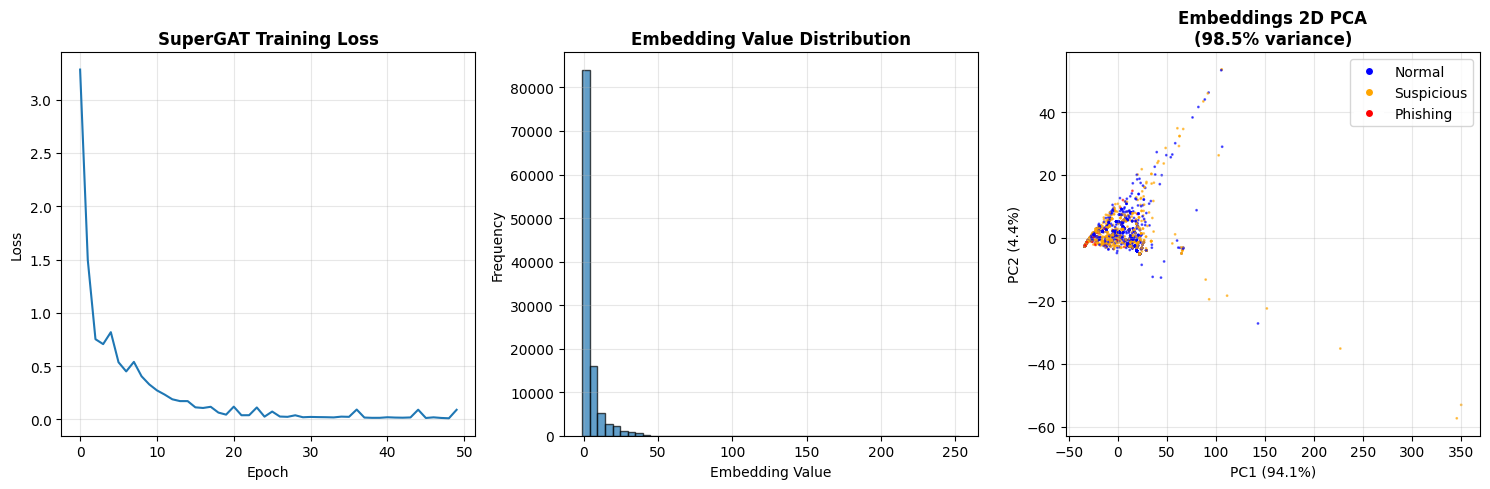

🎯 Layer 1 (SuperGAT) completed successfully!
   📊 Generated embeddings for 3,518 nodes
   📐 Embedding dimension: 32
   📈 Training converged with final loss: 0.0909
   🎯 Dataset ready for evaluation with 73 phishing + 1632 suspicious nodes
📊 SuperGAT training analysis saved to Dataset/Figures/supergat_training_analysis.png


In [ ]:
# Step 8.1: Layer 1 - SuperGAT for Graph Neural Network Embedding (OPTIMIZED + MIXED DATA)
print("🔄 Step 8.1: Training SuperGAT for Graph Embeddings...")

class SuperGATEncoder(nn.Module):
    """
    SuperGAT-based Graph Neural Network for self-supervised node embedding learning.
    Uses attention mechanism to capture transaction patterns in Ethereum graph.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4, dropout=0.3):
        super(SuperGATEncoder, self).__init__()
        
        # Multi-head GAT layers with edge prediction capability
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout, concat=True)
        self.gat2 = GATConv(hidden_dim * num_heads, output_dim, heads=1, dropout=dropout, concat=False)
        
        # Edge prediction layer for self-supervised learning
        self.edge_predictor = nn.Sequential(
            nn.Linear(output_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, return_attention=False):
        """
        Forward pass through SuperGAT layers
        
        Args:
            x: Node features [N, input_dim]
            edge_index: Edge connectivity [2, E]
            return_attention: Whether to return attention weights
        
        Returns:
            node_embeddings: Learned node representations [N, output_dim]
            edge_predictions: Predicted edge existence probabilities [E]
        """
        # First GAT layer with attention
        h1 = self.gat1(x, edge_index)
        h1 = F.elu(h1)
        h1 = self.dropout(h1)
        
        # Second GAT layer
        node_embeddings = self.gat2(h1, edge_index)
        node_embeddings = F.elu(node_embeddings)
        
        # Edge prediction for self-supervised learning
        edge_predictions = self.predict_edges(node_embeddings, edge_index)
        
        return node_embeddings, edge_predictions
    
    def predict_edges(self, embeddings, edge_index):
        """Predict edge existence based on node embeddings"""
        src_embeddings = embeddings[edge_index[0]]
        tgt_embeddings = embeddings[edge_index[1]]
        edge_features = torch.cat([src_embeddings, tgt_embeddings], dim=1)
        edge_predictions = self.edge_predictor(edge_features).squeeze()
        return edge_predictions

def train_supergat_model(data, epochs=150, learning_rate=1e-3, hidden_dim=64, output_dim=32):
    """
    Train SuperGAT model for node embedding learning with edge prediction
    
    Args:
        data: PyTorch Geometric Data object
        epochs: Number of training epochs
        learning_rate: Learning rate for optimization
        hidden_dim: Hidden layer dimension
        output_dim: Output embedding dimension
    
    Returns:
        model: Trained SuperGAT model
        embeddings: Final node embeddings
        training_history: Loss history during training
    """
    print(f"🚀 Training SuperGAT model...")
    print(f"   • Architecture: {data.x.shape[1]} → {hidden_dim} → {output_dim}")
    print(f"   • Training epochs: {epochs}")
    print(f"   • Learning rate: {learning_rate}")
    
    # Initialize model
    model = SuperGATEncoder(
        input_dim=data.x.shape[1],
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        num_heads=4,
        dropout=0.3
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Edge labels for self-supervised learning (all edges exist)
    edge_labels = torch.ones(data.edge_index.shape[1], dtype=torch.float).to(device)
    
    training_history = []
    model.train()
    
    print(f"   🔄 Training progress:")
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        embeddings, edge_predictions = model(data.x, data.edge_index)
        
        # Edge prediction loss
        edge_loss = F.binary_cross_entropy(edge_predictions, edge_labels)
        
        # Fixed diversity regularization - encourage diversity without negative loss
        # Use the reciprocal of variance to encourage higher variance (more diversity)
        embedding_var = torch.var(embeddings, dim=0).mean()
        diversity_loss = 1.0 / (embedding_var + 1e-6)  # Add small epsilon to prevent division by zero
        
        # Combined loss with reduced diversity weight
        total_loss = edge_loss + 0.01 * diversity_loss  # Reduced weight from 0.1 to 0.01
        
        total_loss.backward()
        optimizer.step()
        
        training_history.append(total_loss.item())
        
        # Print progress every 30 epochs
        if (epoch + 1) % 30 == 0 or epoch == 0:
            print(f"      Epoch {epoch + 1:3d}/{epochs}: Loss = {total_loss.item():.4f}, "
                  f"Edge Loss = {edge_loss.item():.4f}, Diversity = {diversity_loss.item():.4f}")
    
    model.eval()
    with torch.no_grad():
        final_embeddings, _ = model(data.x, data.edge_index)
        final_embeddings = final_embeddings.cpu().numpy()
    
    print(f"   ✅ SuperGAT training completed!")
    print(f"   📊 Final embedding shape: {final_embeddings.shape}")
    print(f"   📈 Final loss: {training_history[-1]:.4f}")
    
    return model, final_embeddings, training_history

def compute_graph_features_fast(subgraph, final_nodes, max_nodes_for_pagerank=50000):
    """
    Fast computation of graph features using vectorized operations
    Compatible with MultiDiGraph by converting to simple graph first
    
    Args:
        subgraph: NetworkX graph (MultiDiGraph)
        final_nodes: List of nodes
        max_nodes_for_pagerank: Skip PageRank if graph is too large
    
    Returns:
        node_features: List of [degree, clustering, pagerank] for each node
    """
    print("📊 Computing graph features (optimized for MultiDiGraph)...")
    
    # Convert MultiDiGraph to simple Graph for clustering computation
    print("   • Converting MultiDiGraph to simple Graph...")
    simple_graph = nx.Graph(subgraph)  # This removes multi-edges and directions
    
    # Method 1: Batch compute all degrees at once (use original graph for degree)
    print("   • Computing degrees...")
    degrees = dict(subgraph.degree())  # Use original MultiDiGraph for degree
    
    # Method 2: Batch compute clustering coefficients (use simple graph)
    print("   • Computing clustering coefficients...")
    clustering_dict = nx.clustering(simple_graph)  # Use simple graph for clustering
    
    # Method 3: Conditional PageRank computation (use simple graph)
    print(f"   • Computing PageRank (nodes: {len(final_nodes):,})...")
    if len(final_nodes) <= max_nodes_for_pagerank:
        pagerank_dict = nx.pagerank(simple_graph, max_iter=50)  # Use simple graph
        print("     ✅ Full PageRank computed")
    else:
        # For large graphs, use simplified approach
        print("     ⚡ Using fast approximation for large graph")
        # Use degree centrality as approximation (much faster)
        total_edges = simple_graph.number_of_edges()
        pagerank_dict = {node: degrees[node] / (2 * total_edges) if total_edges > 0 else 1.0/len(final_nodes) 
                        for node in final_nodes}
    
    # Method 4: Vectorized feature assembly
    print("   • Assembling features...")
    node_features = []
    for node in final_nodes:
        degree = degrees[node]
        clustering = clustering_dict.get(node, 0.0)  # Default to 0 if not found
        pagerank = pagerank_dict.get(node, 1.0/len(final_nodes))  # Default uniform
        node_features.append([degree, clustering, pagerank])
    
    print(f"   ✅ Features computed for {len(final_nodes):,} nodes")
    return node_features

def create_mixed_training_data(training_nodes, test_nodes, phishing_nodes, suspicious_nodes, 
                              max_training=40000, max_test=10000):
    """
    Create a mixed dataset with training nodes + test nodes for proper evaluation
    
    Args:
        training_nodes: List of training nodes (normal)
        test_nodes: List of test nodes (contains phishing/suspicious)
        phishing_nodes: List of phishing nodes
        suspicious_nodes: List of suspicious nodes  
        max_training: Max number of training nodes to include
        max_test: Max number of test nodes to include
    
    Returns:
        mixed_nodes: List of mixed nodes
        node_labels: Dict with node labels for evaluation
    """
    print("📊 Creating mixed training+test dataset for evaluation...")
    
    # Sample training nodes (normal nodes)
    training_sample = random.sample(training_nodes, min(max_training, len(training_nodes)))
    print(f"   • Selected {len(training_sample):,} training nodes (normal)")
    
    # Sample test nodes (includes phishing/suspicious)
    test_sample = random.sample(test_nodes, min(max_test, len(test_nodes)))
    print(f"   • Selected {len(test_sample):,} test nodes")
    
    # Analyze test sample composition
    test_phishing = [node for node in test_sample if node in phishing_nodes]
    test_suspicious = [node for node in test_sample if node in suspicious_nodes]  
    test_normal = [node for node in test_sample if node not in phishing_nodes and node not in suspicious_nodes]
    
    print(f"   📊 Test sample composition:")
    print(f"      • Normal: {len(test_normal):,}")
    print(f"      • Phishing: {len(test_phishing):,}")
    print(f"      • Suspicious: {len(test_suspicious):,}")
    
    # Combine training and test nodes
    mixed_nodes = training_sample + test_sample
    print(f"   ✅ Mixed dataset: {len(mixed_nodes):,} total nodes")
    
    # Create node labels for evaluation
    node_labels = {}
    for node in mixed_nodes:
        if node in phishing_nodes:
            node_labels[node] = 'phishing'
        elif node in suspicious_nodes:
            node_labels[node] = 'suspicious'
        else:
            node_labels[node] = 'normal'
    
    label_counts = {label: sum(1 for v in node_labels.values() if v == label) 
                   for label in ['normal', 'phishing', 'suspicious']}
    print(f"   📊 Final dataset composition: {label_counts}")
    
    return mixed_nodes, node_labels

# Complete data loading and training pipeline (MIXED DATA VERSION)
try:
    print("🎯 Starting SuperGAT training pipeline (MIXED DATA VERSION)...")
    print("📂 Loading required data (completely independent)...")
    
    # Load graph data
    print("   🔄 Loading graph...")
    with open("Dataset/MulDiGraph.pkl", "rb") as f:
        G = pickle.load(f)
    print(f"      ✅ Graph loaded: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
    
    # Load training nodes
    print("   🔄 Loading training nodes...")
    with open("Dataset/training_nodes.pkl", "rb") as f:
        training_nodes = pickle.load(f)
    print(f"      ✅ Training nodes loaded: {len(training_nodes):,} nodes")
    
    # Load test nodes 
    print("   🔄 Loading test nodes...")
    with open("Dataset/test_nodes.pkl", "rb") as f:
        test_nodes = pickle.load(f)
    print(f"      ✅ Test nodes loaded: {len(test_nodes):,} nodes")
    
    # Load node labels
    print("   🔄 Loading node labels...")
    with open("Dataset/Processed/phishing_nodes.pkl", "rb") as f:
        phishing_nodes = pickle.load(f)
    with open("Dataset/Processed/suspicious_nodes.pkl", "rb") as f:
        suspicious_nodes = pickle.load(f)
    print(f"      ✅ Node labels loaded: {len(phishing_nodes):,} phishing, {len(suspicious_nodes):,} suspicious")
    
    # Create mixed dataset for training and evaluation
    mixed_nodes, node_labels = create_mixed_training_data(
        training_nodes, test_nodes, phishing_nodes, suspicious_nodes,
        max_training=40000, max_test=10000
    )
    
    # Create subgraph from mixed nodes
    print("📊 Creating subgraph from mixed dataset...")
    subset_subgraph = G.subgraph(mixed_nodes).copy()
    
    # Remove isolated nodes
    isolated_nodes = [node for node in subset_subgraph.nodes() if subset_subgraph.degree(node) == 0]
    if isolated_nodes:
        subset_subgraph.remove_nodes_from(isolated_nodes)
        print(f"   • Removed {len(isolated_nodes):,} isolated nodes")
        # Update node_labels to remove isolated nodes
        for node in isolated_nodes:
            if node in node_labels:
                del node_labels[node]
    
    final_nodes = list(subset_subgraph.nodes())
    print(f"   ✅ Final subgraph: {len(final_nodes):,} nodes, {subset_subgraph.number_of_edges():,} edges")
    
    # Analyze final composition
    final_composition = {label: sum(1 for node in final_nodes if node_labels.get(node) == label) 
                        for label in ['normal', 'phishing', 'suspicious']}
    print(f"   📊 Final composition: {final_composition}")
    
    # Fast feature computation
    node_features = compute_graph_features_fast(subset_subgraph, final_nodes, max_nodes_for_pagerank=50000)
    
    # Create graph data for SuperGAT
    print("📊 Preparing graph data for SuperGAT...")
    
    # Create node mapping
    node_mapping = {node: i for i, node in enumerate(final_nodes)}
    
    # Edge list (optimized)
    print("   • Building edge list...")
    edge_list = []
    for edge in subset_subgraph.edges():
        src_idx = node_mapping[edge[0]]
        tgt_idx = node_mapping[edge[1]]
        edge_list.append([src_idx, tgt_idx])
        edge_list.append([tgt_idx, src_idx])  # Add reverse edge for undirected graph
    
    # Convert to PyTorch tensors
    print("   • Converting to PyTorch tensors...")
    x = torch.FloatTensor(node_features).to(device)
    edge_index = torch.LongTensor(edge_list).t().contiguous().to(device)
    
    # Create PyTorch Geometric data object
    graph_data = Data(x=x, edge_index=edge_index)
    
    print(f"   ✅ Graph data prepared: {graph_data.x.shape[0]} nodes, {graph_data.edge_index.shape[1]} edges, {graph_data.x.shape[1]} features")
    
    # Train SuperGAT model
    print("🚀 Starting SuperGAT training...")
    supergat_model, node_embeddings, training_history = train_supergat_model(
        graph_data, epochs=50, learning_rate=1e-3, hidden_dim=64, output_dim=32  # Reduced epochs for testing
    )
    
    # Save results with node labels for evaluation
    os.makedirs("Dataset/Models", exist_ok=True)
    supergat_results = {
        'model_state_dict': supergat_model.state_dict(),
        'embeddings': node_embeddings,
        'node_list': final_nodes,
        'node_labels': node_labels,  # Include labels for evaluation
        'training_history': training_history,
        'node_mapping': node_mapping,
        'final_composition': final_composition
    }
    
    with open("Dataset/Models/supergat_results.pkl", "wb") as f:
        pickle.dump(supergat_results, f)
    
    print("💾 SuperGAT results saved to Dataset/Models/supergat_results.pkl")
    
    # Visualize training progress and embeddings
    plt.figure(figsize=(15, 5))
    
    # Training loss
    plt.subplot(1, 3, 1)
    plt.plot(training_history)
    plt.title('SuperGAT Training Loss', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Embedding value distribution
    plt.subplot(1, 3, 2)
    plt.hist(node_embeddings.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.title('Embedding Value Distribution', fontweight='bold')
    plt.xlabel('Embedding Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # 2D visualization of embeddings using PCA
    plt.subplot(1, 3, 3)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(node_embeddings)
    
    # Color by node type
    colors = []
    for node in final_nodes:
        if node_labels.get(node) == 'phishing':
            colors.append('red')
        elif node_labels.get(node) == 'suspicious':
            colors.append('orange')
        else:
            colors.append('blue')
    
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6, s=1)
    plt.title(f'Embeddings 2D PCA\n({pca.explained_variance_ratio_.sum():.1%} variance)', fontweight='bold')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='Normal'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='Suspicious'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Phishing')]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.savefig("Dataset/Figures/supergat_training_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("🎯 Layer 1 (SuperGAT) completed successfully!")
    print(f"   📊 Generated embeddings for {len(final_nodes):,} nodes")
    print(f"   📐 Embedding dimension: {node_embeddings.shape[1]}")
    print(f"   📈 Training converged with final loss: {training_history[-1]:.4f}")
    print(f"   🎯 Dataset ready for evaluation with {final_composition['phishing']} phishing + {final_composition['suspicious']} suspicious nodes")
    
    print(f"📊 SuperGAT training analysis saved to Dataset/Figures/supergat_training_analysis.png")
    
except Exception as e:
    print(f"❌ Error in SuperGAT training: {e}")
    import traceback
    traceback.print_exc()


🔄 Step 8.2: Training Autoencoder for Latent Compression...
🎯 Starting Autoencoder training pipeline...
📂 Loading SuperGAT embeddings...
   ✅ SuperGAT results loaded from file
   📊 Embeddings: (3518, 32)
   📊 Nodes: 3,518
📂 Loading node labels...
   ✅ Using node labels from SuperGAT results
📊 Dataset composition:
   • Normal: 1,813
   • Phishing: 73
   • Suspicious: 1,632
   • Training on 1,813 normal nodes
🚀 Training Autoencoder...
   • Training samples: 1,813 normal nodes
   • Total samples: 3,518 nodes
   • Input dimension: 32
   🔄 Training progress:
      Epoch   1/100: Loss = 1.022540
      Epoch  20/100: Loss = 0.208081
      Epoch  20/100: Loss = 0.208081
      Epoch  40/100: Loss = 0.090658
      Epoch  60/100: Loss = 0.066217
      Epoch  40/100: Loss = 0.090658
      Epoch  60/100: Loss = 0.066217
      Epoch  80/100: Loss = 0.052496
      Epoch 100/100: Loss = 0.052357
   🔄 Computing latent representations and reconstruction errors...
   ✅ Autoencoder training completed!
   

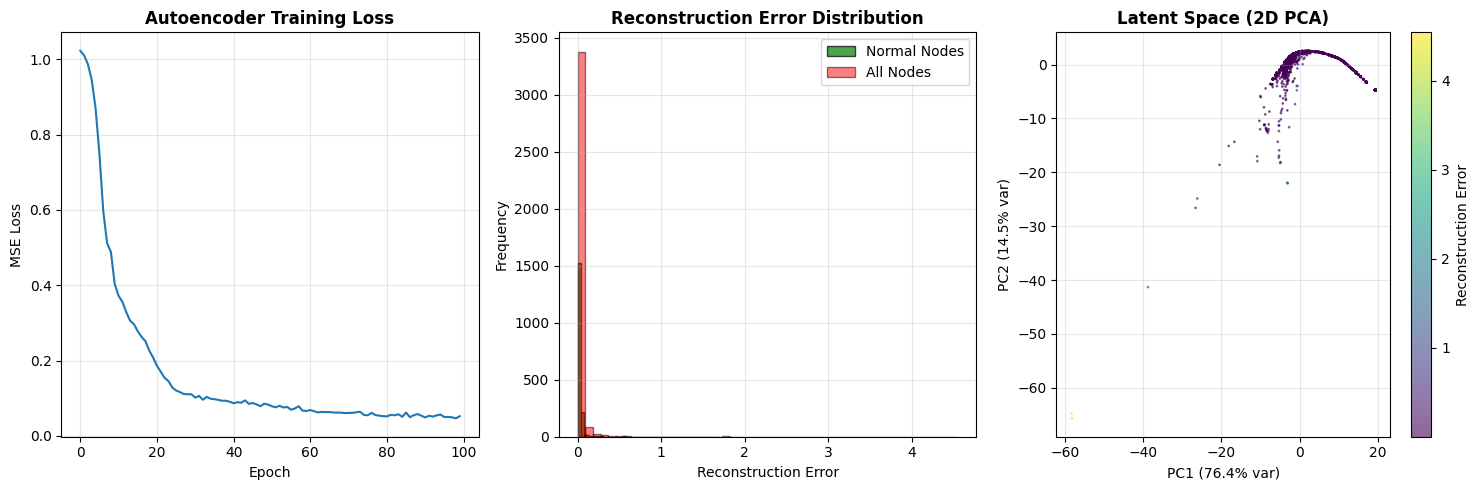

🎯 Layer 2 (Autoencoder) completed successfully!
   📊 Processed embeddings for 3,518 nodes
   📐 Latent dimension: 16
   📈 Training converged with final loss: 0.052357


In [ ]:
# Step 8.2: Layer 2 - Autoencoder for Latent Compression
print("\n🔄 Step 8.2: Training Autoencoder for Latent Compression...")

def load_supergat_results():
    """
    Load SuperGAT embeddings and node list from saved results
    
    Returns:
        node_embeddings: SuperGAT node embeddings
        node_list: List of nodes corresponding to embeddings
    """
    print("📂 Loading SuperGAT embeddings...")
    
    try:
        with open("Dataset/Models/supergat_results.pkl", "rb") as f:
            supergat_data = pickle.load(f)
        print("   ✅ SuperGAT results loaded from file")
        
        # Fixed: Use correct key names from the saved file
        node_embeddings = supergat_data['embeddings']  # Changed from 'node_embeddings' to 'embeddings'
        node_list = supergat_data['node_list']
        print(f"   📊 Embeddings: {node_embeddings.shape}")
        print(f"   📊 Nodes: {len(node_list):,}")
        
        return node_embeddings, node_list
        
    except FileNotFoundError:
        print("   ❌ SuperGAT results file not found! Please run SuperGAT training first.")
        raise
    except KeyError as e:
        print(f"   ❌ Error loading SuperGAT results: {e}")
        print("   📋 Available keys in file:", list(supergat_data.keys()))
        raise

class AnomalyAutoencoder(nn.Module):
    """
    Autoencoder for anomaly detection using reconstruction error
    
    Architecture:
    - Encoder: input -> 64 -> 32 -> 16
    - Decoder: 16 -> 32 -> 64 -> input
    """
    def __init__(self, input_dim, latent_dim=16):
        super(AnomalyAutoencoder, self).__init__()
        
        # Encoder layers with dropout for regularization
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, latent_dim)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
        
    def forward(self, x):
        """
        Forward pass through autoencoder
        
        Args:
            x: Input embeddings [batch_size, input_dim]
        
        Returns:
            latent: Latent representations [batch_size, latent_dim]
            reconstructed: Reconstructed embeddings [batch_size, input_dim]
        """
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

def train_autoencoder(embeddings, normal_indices, epochs=100, batch_size=512, learning_rate=1e-3):
    """
    Train autoencoder on normal nodes only
    
    Args:
        embeddings: All node embeddings
        normal_indices: Indices of normal nodes
        epochs: Training epochs
        batch_size: Batch size
        learning_rate: Learning rate
    
    Returns:
        model: Trained autoencoder
        training_history: Loss history
        all_latent: Latent representations for all nodes
        all_reconstruction_errors: Reconstruction errors for all nodes
    """
    print("🚀 Training Autoencoder...")
    
    # Filter normal embeddings for training
    normal_embeddings = embeddings[normal_indices]
    print(f"   • Training samples: {len(normal_embeddings):,} normal nodes")
    print(f"   • Total samples: {len(embeddings):,} nodes")
    print(f"   • Input dimension: {embeddings.shape[1]}")
    
    # Standardize embeddings
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    normal_embeddings_scaled = scaler.fit_transform(normal_embeddings)
    all_embeddings_scaled = scaler.transform(embeddings)
    
    # Convert to tensors
    normal_embeddings_tensor = torch.FloatTensor(normal_embeddings_scaled).to(device)
    all_embeddings_tensor = torch.FloatTensor(all_embeddings_scaled).to(device)
    
    # Initialize model
    input_dim = embeddings.shape[1]
    model = AnomalyAutoencoder(
        input_dim=input_dim,
        latent_dim=16
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Training loop
    training_history = []
    model.train()
    
    print(f"   🔄 Training progress:")
    
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        
        # Process in batches
        for i in range(0, len(normal_embeddings_tensor), batch_size):
            batch_data = normal_embeddings_tensor[i:i+batch_size]
            
            optimizer.zero_grad()
            
            latent, reconstructed = model(batch_data)
            loss = criterion(reconstructed, batch_data)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        training_history.append(avg_loss)
        
        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"      Epoch {epoch + 1:3d}/{epochs}: Loss = {avg_loss:.6f}")
    
    # Generate latent representations and reconstruction errors for all nodes
    print("   🔄 Computing latent representations and reconstruction errors...")
    model.eval()
    with torch.no_grad():
        # Process in batches to avoid memory issues
        all_latent_list = []
        all_reconstruction_errors_list = []
        
        batch_size_inference = 1024
        for i in range(0, len(all_embeddings_tensor), batch_size_inference):
            batch_data = all_embeddings_tensor[i:i+batch_size_inference]
            latent, reconstructed = model(batch_data)
            
            # Compute reconstruction errors for this batch
            reconstruction_errors = torch.mean((batch_data - reconstructed) ** 2, dim=1)
            
            all_latent_list.append(latent.cpu().numpy())
            all_reconstruction_errors_list.append(reconstruction_errors.cpu().numpy())
        
        # Concatenate all batches
        all_latent = np.concatenate(all_latent_list, axis=0)
        all_reconstruction_errors = np.concatenate(all_reconstruction_errors_list, axis=0)
    
    print(f"   ✅ Autoencoder training completed!")
    print(f"   📊 Latent dimension: {all_latent.shape[1]}")
    print(f"   📈 Final training loss: {training_history[-1]:.6f}")
    print(f"   📊 Reconstruction error range: [{all_reconstruction_errors.min():.6f}, {all_reconstruction_errors.max():.6f}]")
    
    return model, training_history, all_latent, all_reconstruction_errors, scaler

# Complete autoencoder training pipeline
try:
    print("🎯 Starting Autoencoder training pipeline...")
    
    # Load SuperGAT embeddings
    node_embeddings, node_list = load_supergat_results()
    
    # Load node labels to identify normal nodes
    print("📂 Loading node labels...")
    try:
        # Try to load from SuperGAT results first
        with open("Dataset/Models/supergat_results.pkl", "rb") as f:
            supergat_data = pickle.load(f)
        
        if 'node_labels' in supergat_data:
            node_labels = supergat_data['node_labels']
            print("   ✅ Using node labels from SuperGAT results")
        else:
            # Fallback to original label files
            print("   🔄 Loading original label files...")
            with open("Dataset/Processed/phishing_nodes.pkl", "rb") as f:
                phishing_nodes = pickle.load(f)
            with open("Dataset/Processed/suspicious_nodes.pkl", "rb") as f:
                suspicious_nodes = pickle.load(f)
            
            # Create node labels dict
            node_labels = {}
            for node in node_list:
                if node in phishing_nodes:
                    node_labels[node] = 'phishing'
                elif node in suspicious_nodes:
                    node_labels[node] = 'suspicious'
                else:
                    node_labels[node] = 'normal'
            print("   ✅ Created node labels from original files")
        
    except Exception as e:
        print(f"   ❌ Error loading labels: {e}")
        raise
    
    # Identify normal node indices
    normal_indices = [i for i, node in enumerate(node_list) if node_labels.get(node) == 'normal']
    
    print(f"📊 Dataset composition:")
    label_counts = {}
    for label in ['normal', 'phishing', 'suspicious']:
        count = sum(1 for node in node_list if node_labels.get(node) == label)
        label_counts[label] = count
        print(f"   • {label.capitalize()}: {count:,}")
    
    print(f"   • Training on {len(normal_indices):,} normal nodes")
    
    # Train autoencoder with moderate parameters
    autoencoder_model, ae_training_history, all_latent_representations, all_reconstruction_errors, scaler = train_autoencoder(
        node_embeddings, normal_indices, 
        epochs=100,       # Moderate epochs
        batch_size=512,   # Standard batch size
        learning_rate=1e-3
    )
    
    # Save autoencoder results
    autoencoder_results = {
        'model_state_dict': autoencoder_model.state_dict(),
        'training_history': ae_training_history,
        'latent_representations': all_latent_representations,
        'reconstruction_errors': all_reconstruction_errors,
        'normal_indices': normal_indices,
        'scaler': scaler,
        'label_counts': label_counts
    }
    
    with open("Dataset/Models/autoencoder_results.pkl", "wb") as f:
        pickle.dump(autoencoder_results, f)
    
    print("💾 Autoencoder results saved to Dataset/Models/autoencoder_results.pkl")
    
    # Visualize results
    normal_recon_errors = all_reconstruction_errors[normal_indices]
    
    plt.figure(figsize=(15, 5))
    
    # Training loss
    plt.subplot(1, 3, 1)
    plt.plot(ae_training_history)
    plt.title('Autoencoder Training Loss', fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True, alpha=0.3)
    
    # Reconstruction error distribution
    plt.subplot(1, 3, 2)
    plt.hist(normal_recon_errors, bins=50, alpha=0.7, color='green', label='Normal Nodes', edgecolor='black')
    plt.hist(all_reconstruction_errors, bins=50, alpha=0.5, color='red', label='All Nodes', edgecolor='black')
    plt.title('Reconstruction Error Distribution', fontweight='bold')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Latent space visualization (2D projection)
    plt.subplot(1, 3, 3)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(all_latent_representations)
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=all_reconstruction_errors, 
               cmap='viridis', alpha=0.6, s=1)
    plt.colorbar(label='Reconstruction Error')
    plt.title('Latent Space (2D PCA)', fontweight='bold')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("Dataset/Figures/autoencoder_training_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("🎯 Layer 2 (Autoencoder) completed successfully!")
    print(f"   📊 Processed embeddings for {len(node_list):,} nodes")
    print(f"   📐 Latent dimension: {all_latent_representations.shape[1]}")
    print(f"   📈 Training converged with final loss: {ae_training_history[-1]:.6f}")
    
except Exception as e:
    print(f"❌ Error in Autoencoder training: {e}")
    import traceback
    traceback.print_exc()


🔄 Step 8.3: Training One-Class SVM for Anomaly Detection...
🎯 Starting One-Class SVM training on normal latent vectors...
📊 Preparing latent features for One-Class SVM...
   • Total latent vectors: 3,518
   • Normal latent vectors: 1,813
   • Latent dimension: 16
   • Normal ratio: 51.5%
🚀 Training One-Class SVM...
   • Training samples: 1,813
   • Feature dimension: 16
   • Kernel: rbf
   • Nu (outlier fraction): 0.05
   • Gamma: scale
   🔄 Fitting One-Class SVM on normal latent vectors...
   ✅ One-Class SVM training completed!
   📊 Support vectors: 97 (5.4%)
   📈 Training outlier fraction: 0.063
   📊 Decision function range: [-11.572, 1.794]
📊 Computing SVM anomaly scores for all nodes...
   📊 SVM score range: [-1.794, 12.572]
   📈 Predicted outliers: 410 (11.7%)
💾 One-Class SVM results saved to Dataset/Models/svm_results.pkl
🎯 Layer 3 (One-Class SVM) completed successfully!
   📊 Processed 3,518 nodes
   📐 Support vectors: 97
   📈 Anomaly score range: [-1.794, 12.572]


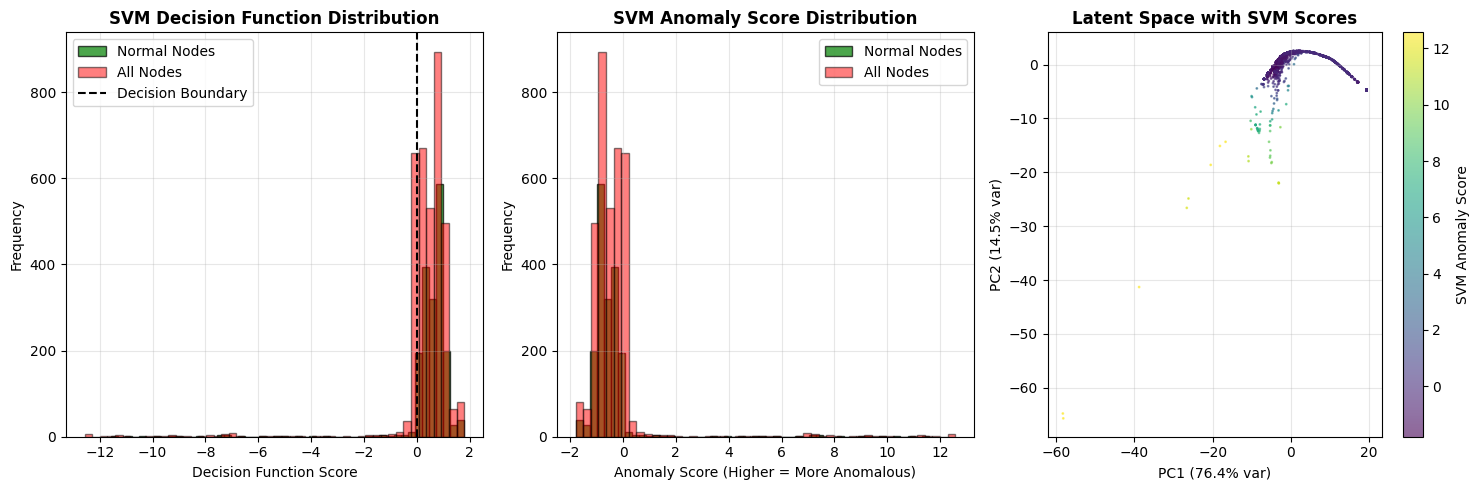

📊 SVM analysis saved to Dataset/Figures/svm_training_analysis.png


In [ ]:
# Step 8.3: Layer 3 - One-Class SVM for Anomaly Boundary Learning
print("\n🔄 Step 8.3: Training One-Class SVM for Anomaly Detection...")

def prepare_latent_features_for_svm():
    """
    Prepare latent representations for One-Class SVM training.
    Only uses latent vectors from normal nodes for boundary learning.
    
    Returns:
        normal_latent_features: Latent vectors from normal nodes
        all_latent_features: Latent vectors from all nodes
        normal_latent_indices: Indices of normal nodes in latent space
    """
    print("📊 Preparing latent features for One-Class SVM...")
    
    # Get latent representations
    all_latent = all_latent_representations
    
    # Filter for normal nodes only (same indices as for autoencoder)
    normal_latent_features = all_latent[normal_indices]
    
    print(f"   • Total latent vectors: {len(all_latent):,}")
    print(f"   • Normal latent vectors: {len(normal_latent_features):,}")
    print(f"   • Latent dimension: {all_latent.shape[1]}")
    print(f"   • Normal ratio: {len(normal_latent_features)/len(all_latent)*100:.1f}%")
    
    return normal_latent_features, all_latent, normal_indices

def train_one_class_svm(normal_latent_vectors, nu=0.05, gamma='scale', kernel='rbf'):
    """
    Train One-Class SVM on normal latent representations for anomaly boundary learning
    
    Args:
        normal_latent_vectors: Latent vectors from normal nodes [N_normal, latent_dim]
        nu: Upper bound on the fraction of training errors (expected outlier fraction)
        gamma: Kernel coefficient for 'rbf'
        kernel: Kernel type for SVM
    
    Returns:
        svm_model: Trained One-Class SVM model
        svm_training_stats: Training statistics
    """
    print(f"🚀 Training One-Class SVM...")
    print(f"   • Training samples: {len(normal_latent_vectors):,}")
    print(f"   • Feature dimension: {normal_latent_vectors.shape[1]}")
    print(f"   • Kernel: {kernel}")
    print(f"   • Nu (outlier fraction): {nu}")
    print(f"   • Gamma: {gamma}")
    
    # Standardize latent features for SVM
    latent_scaler = StandardScaler()
    normal_latent_scaled = latent_scaler.fit_transform(normal_latent_vectors)
    
    # Initialize and train One-Class SVM
    svm_model = OneClassSVM(
        kernel=kernel,
        gamma=gamma,
        nu=nu,
        cache_size=1000  # Increase cache for better performance
    )
    
    print("   🔄 Fitting One-Class SVM on normal latent vectors...")
    svm_model.fit(normal_latent_scaled)
    
    # Evaluate on training data to get statistics
    train_decisions = svm_model.decision_function(normal_latent_scaled)
    train_predictions = svm_model.predict(normal_latent_scaled)
    
    # Calculate training statistics
    support_vectors_count = len(svm_model.support_vectors_)
    outlier_fraction = np.sum(train_predictions == -1) / len(train_predictions)
    
    svm_training_stats = {
        'support_vectors_count': support_vectors_count,
        'support_vector_ratio': support_vectors_count / len(normal_latent_vectors),
        'training_outlier_fraction': outlier_fraction,
        'decision_function_range': (train_decisions.min(), train_decisions.max()),
        'decision_function_mean': train_decisions.mean(),
        'decision_function_std': train_decisions.std()
    }
    
    print(f"   ✅ One-Class SVM training completed!")
    print(f"   📊 Support vectors: {support_vectors_count:,} ({support_vectors_count/len(normal_latent_vectors)*100:.1f}%)")
    print(f"   📈 Training outlier fraction: {outlier_fraction:.3f}")
    print(f"   📊 Decision function range: [{train_decisions.min():.3f}, {train_decisions.max():.3f}]")
    
    return svm_model, latent_scaler, svm_training_stats

def compute_svm_anomaly_scores(svm_model, latent_scaler, all_latent_vectors):
    """
    Compute SVM anomaly scores for all nodes
    
    Args:
        svm_model: Trained One-Class SVM model
        latent_scaler: Fitted StandardScaler for latent features
        all_latent_vectors: Latent vectors for all nodes
    
    Returns:
        svm_scores: SVM anomaly scores (higher = more anomalous)
        svm_predictions: SVM binary predictions (-1: outlier, 1: normal)
    """
    print("📊 Computing SVM anomaly scores for all nodes...")
    
    # Scale all latent vectors using fitted scaler
    all_latent_scaled = latent_scaler.transform(all_latent_vectors)
    
    # Get decision function scores (distance to separating hyperplane)
    decision_scores = svm_model.decision_function(all_latent_scaled)
    
    # Convert to anomaly scores (negative decision_function = more anomalous)
    # Higher anomaly score means more likely to be an outlier
    svm_anomaly_scores = -decision_scores
    
    # Get binary predictions
    svm_predictions = svm_model.predict(all_latent_scaled)
    
    print(f"   📊 SVM score range: [{svm_anomaly_scores.min():.3f}, {svm_anomaly_scores.max():.3f}]")
    print(f"   📈 Predicted outliers: {np.sum(svm_predictions == -1):,} ({np.sum(svm_predictions == -1)/len(svm_predictions)*100:.1f}%)")
    
    return svm_anomaly_scores, svm_predictions

# Execute One-Class SVM training
print("🎯 Starting One-Class SVM training on normal latent vectors...")

# Prepare latent features
normal_latent, all_latent, normal_latent_indices = prepare_latent_features_for_svm()

# Train One-Class SVM
svm_model, latent_scaler, svm_stats = train_one_class_svm(
    normal_latent,
    nu=0.05,          # Expect 5% outliers in training data
    gamma='scale',    # Automatic gamma scaling
    kernel='rbf'      # RBF kernel for non-linear boundaries
)

# Compute anomaly scores for all nodes
svm_anomaly_scores, svm_predictions = compute_svm_anomaly_scores(
    svm_model, 
    latent_scaler, 
    all_latent
)

# Save One-Class SVM results
svm_results = {
    'model': svm_model,
    'latent_scaler': latent_scaler,
    'training_stats': svm_stats,
    'normal_latent_indices': normal_latent_indices,
    'svm_anomaly_scores': svm_anomaly_scores,
    'svm_predictions': svm_predictions,
    'parameters': {
        'nu': 0.05,
        'gamma': 'scale',
        'kernel': 'rbf'
    }
}

with open("Dataset/Models/svm_results.pkl", 'wb') as f:
    pickle.dump(svm_results, f)

print(f"💾 One-Class SVM results saved to Dataset/Models/svm_results.pkl")
print(f"🎯 Layer 3 (One-Class SVM) completed successfully!")
print(f"   📊 Processed {len(all_latent):,} nodes")
print(f"   📐 Support vectors: {svm_stats['support_vectors_count']:,}")
print(f"   📈 Anomaly score range: [{svm_anomaly_scores.min():.3f}, {svm_anomaly_scores.max():.3f}]")

# Visualize SVM results
plt.figure(figsize=(15, 5))

# SVM decision function distribution
plt.subplot(1, 3, 1)
decision_scores = -svm_anomaly_scores  # Convert back to decision function
normal_decisions = decision_scores[normal_indices]
plt.hist(normal_decisions, bins=50, alpha=0.7, color='green', label='Normal Nodes', edgecolor='black')
plt.hist(decision_scores, bins=50, alpha=0.5, color='red', label='All Nodes', edgecolor='black')
plt.axvline(x=0, color='black', linestyle='--', label='Decision Boundary')
plt.title('SVM Decision Function Distribution', fontweight='bold')
plt.xlabel('Decision Function Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Anomaly score distribution
plt.subplot(1, 3, 2)
normal_anomaly_scores = svm_anomaly_scores[normal_indices]
plt.hist(normal_anomaly_scores, bins=50, alpha=0.7, color='green', label='Normal Nodes', edgecolor='black')
plt.hist(svm_anomaly_scores, bins=50, alpha=0.5, color='red', label='All Nodes', edgecolor='black')
plt.title('SVM Anomaly Score Distribution', fontweight='bold')
plt.xlabel('Anomaly Score (Higher = More Anomalous)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 2D visualization of latent space with SVM scores
plt.subplot(1, 3, 3)
# Reuse PCA from previous step or compute new one
if 'latent_2d' not in locals():
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(all_latent)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=svm_anomaly_scores, 
           cmap='viridis', alpha=0.6, s=1)
plt.colorbar(label='SVM Anomaly Score')
plt.title('Latent Space with SVM Scores', fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Dataset/Figures/svm_training_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 SVM analysis saved to Dataset/Figures/svm_training_analysis.png")


🔄 Step 8.4: Fusing Anomaly Scores and Final Evaluation...
🎯 Starting score fusion and evaluation...
🔄 Testing different fusion weight configurations...

   Testing α=0.6, β=0.4...
🔄 Fusing anomaly scores with weights α=0.6, β=0.4...
   📊 Reconstruction error range: [0.001021, 4.545928]
   📊 SVM score range: [-1.794, 12.572]
   📊 Final score range: [0.001, 1.000]
📊 Evaluating anomaly detection performance...
      AUC-ROC: 0.6499

   Testing α=0.5, β=0.5...
🔄 Fusing anomaly scores with weights α=0.5, β=0.5...
   📊 Reconstruction error range: [0.001021, 4.545928]
   📊 SVM score range: [-1.794, 12.572]
   📊 Final score range: [0.000, 1.000]
📊 Evaluating anomaly detection performance...
      AUC-ROC: 0.6467

   Testing α=0.4, β=0.6...
🔄 Fusing anomaly scores with weights α=0.4, β=0.6...
   📊 Reconstruction error range: [0.001021, 4.545928]
   📊 SVM score range: [-1.794, 12.572]
   📊 Final score range: [0.000, 1.000]
📊 Evaluating anomaly detection performance...
      AUC-ROC: 0.6450

   

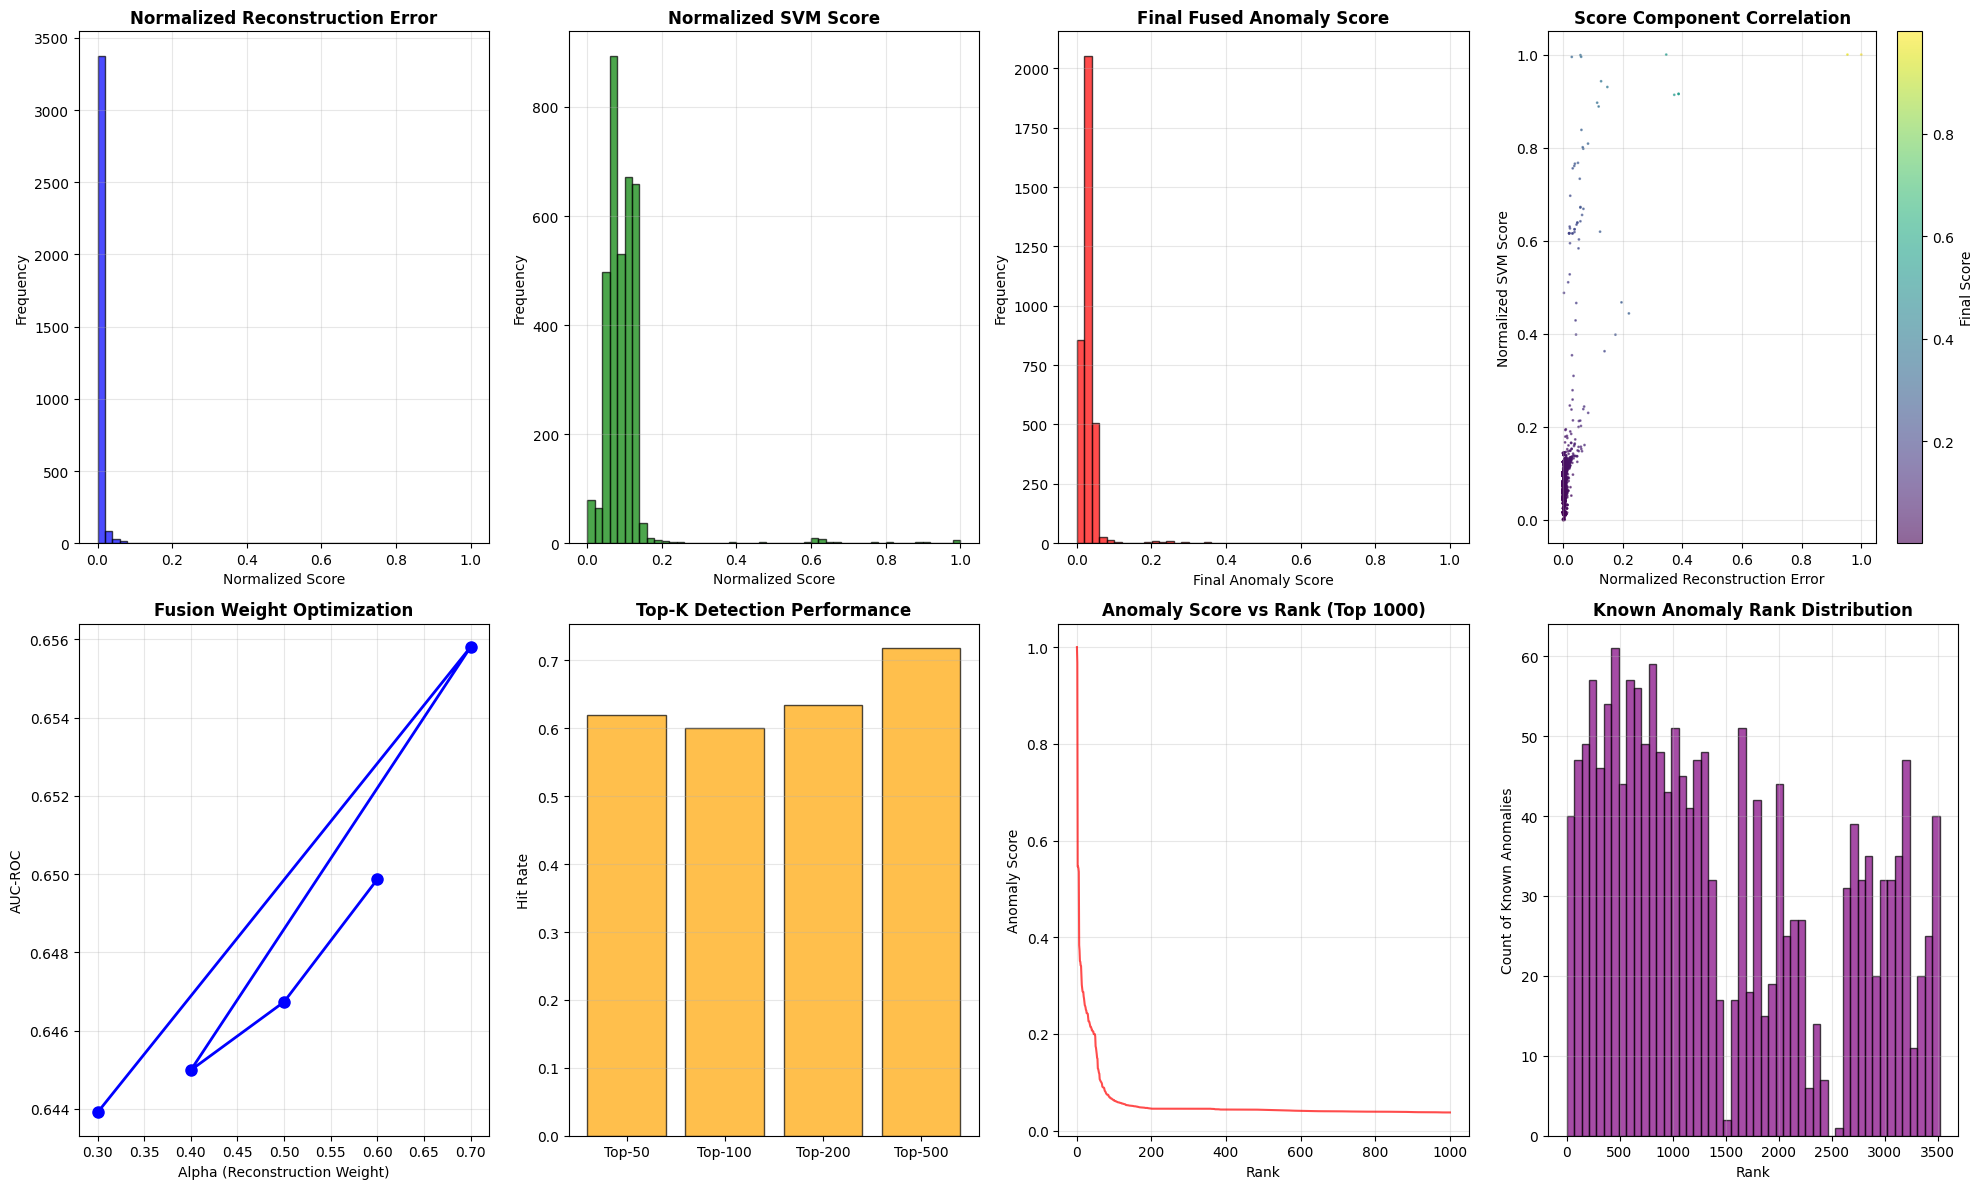

📊 Final analysis visualization saved to Dataset/Figures/final_anomaly_detection_analysis.png


In [ ]:
# Step 8.4: Layer 4 - Score Fusion and Final Evaluation
print("\n🔄 Step 8.4: Fusing Anomaly Scores and Final Evaluation...")

def normalize_scores(scores):
    """Normalize scores to [0, 1] range using min-max scaling"""
    min_score, max_score = scores.min(), scores.max()
    if max_score - min_score == 0:
        return np.zeros_like(scores)
    return (scores - min_score) / (max_score - min_score)

def compute_fusion_scores(reconstruction_errors, svm_scores, alpha=0.6, beta=0.4):
    """
    Fuse reconstruction errors and SVM scores into final anomaly scores
    
    Args:
        reconstruction_errors: Autoencoder reconstruction errors
        svm_scores: One-Class SVM anomaly scores
        alpha: Weight for reconstruction error
        beta: Weight for SVM score
    
    Returns:
        final_scores: Fused anomaly scores
        normalized_recon: Normalized reconstruction errors
        normalized_svm: Normalized SVM scores
    """
    print(f"🔄 Fusing anomaly scores with weights α={alpha}, β={beta}...")
    
    # Normalize both score types to [0, 1] range
    normalized_recon = normalize_scores(reconstruction_errors)
    normalized_svm = normalize_scores(svm_scores)
    
    # Weighted fusion
    final_scores = alpha * normalized_recon + beta * normalized_svm
    
    print(f"   📊 Reconstruction error range: [{reconstruction_errors.min():.6f}, {reconstruction_errors.max():.6f}]")
    print(f"   📊 SVM score range: [{svm_scores.min():.3f}, {svm_scores.max():.3f}]")
    print(f"   📊 Final score range: [{final_scores.min():.3f}, {final_scores.max():.3f}]")
    
    return final_scores, normalized_recon, normalized_svm

def evaluate_anomaly_detection(node_identifiers, final_scores, known_phishing, known_suspicious):
    """
    Evaluate anomaly detection performance using known labels
    
    Args:
        node_identifiers: List of node identifiers
        final_scores: Final anomaly scores
        known_phishing: Set of known phishing nodes
        known_suspicious: Set of known suspicious nodes
    
    Returns:
        evaluation_results: Dictionary containing evaluation metrics
    """
    print("📊 Evaluating anomaly detection performance...")
    
    # Create ground truth labels
    # 1 = anomaly (phishing/suspicious), 0 = normal
    true_labels = []
    valid_indices = []
    
    for i, node in enumerate(node_identifiers):
        if node in known_phishing or node in known_suspicious:
            true_labels.append(1)  # Anomaly
        else:
            true_labels.append(0)  # Normal
        valid_indices.append(i)
    
    true_labels = np.array(true_labels)
    scores_for_eval = final_scores[valid_indices]
    
    # Calculate metrics if we have both classes
    if len(np.unique(true_labels)) > 1:
        # AUC-ROC
        auc_score = roc_auc_score(true_labels, scores_for_eval)
        
        # Precision-Recall curve and AUC-PR
        precision, recall, pr_thresholds = precision_recall_curve(true_labels, scores_for_eval)
        auc_pr = np.trapz(precision, recall)
        
        # Find optimal threshold using F1-score
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = pr_thresholds[optimal_idx] if optimal_idx < len(pr_thresholds) else scores_for_eval.max()
        optimal_f1 = f1_scores[optimal_idx]
        
        # Calculate metrics at different percentile thresholds
        percentile_thresholds = [90, 95, 99]
        percentile_results = {}
        
        for p in percentile_thresholds:
            threshold = np.percentile(scores_for_eval, p)
            predictions = (scores_for_eval >= threshold).astype(int)
            
            if np.sum(predictions) > 0:  # If we made any positive predictions
                precision_p = np.sum((predictions == 1) & (true_labels == 1)) / np.sum(predictions)
                recall_p = np.sum((predictions == 1) & (true_labels == 1)) / np.sum(true_labels) if np.sum(true_labels) > 0 else 0
                f1_p = 2 * precision_p * recall_p / (precision_p + recall_p) if (precision_p + recall_p) > 0 else 0
            else:
                precision_p, recall_p, f1_p = 0, 0, 0
            
            percentile_results[p] = {
                'threshold': threshold,
                'precision': precision_p,
                'recall': recall_p,
                'f1': f1_p,
                'num_predictions': np.sum(predictions)
            }
        
        # Top-K evaluation
        top_k_results = {}
        for k in [50, 100, 200, 500]:
            if k <= len(scores_for_eval):
                top_k_indices = np.argsort(scores_for_eval)[-k:]
                top_k_labels = true_labels[top_k_indices]
                hit_rate = np.sum(top_k_labels) / k
                precision_at_k = hit_rate
                recall_at_k = np.sum(top_k_labels) / np.sum(true_labels) if np.sum(true_labels) > 0 else 0
                
                top_k_results[k] = {
                    'hit_rate': hit_rate,
                    'precision_at_k': precision_at_k,
                    'recall_at_k': recall_at_k,
                    'anomalies_found': np.sum(top_k_labels)
                }
    else:
        print("⚠️ Warning: Only one class present in evaluation data")
        auc_score = auc_pr = optimal_f1 = 0
        percentile_results = {}
        top_k_results = {}
    
    # Basic statistics
    total_nodes = len(node_identifiers)
    total_anomalies = np.sum(true_labels)
    anomaly_rate = total_anomalies / total_nodes if total_nodes > 0 else 0
    
    evaluation_results = {
        'basic_stats': {
            'total_nodes': total_nodes,
            'total_anomalies': total_anomalies,
            'anomaly_rate': anomaly_rate,
            'normal_nodes': total_nodes - total_anomalies
        },
        'performance_metrics': {
            'auc_roc': auc_score,
            'auc_pr': auc_pr,
            'optimal_f1': optimal_f1,
            'optimal_threshold': optimal_threshold if 'optimal_threshold' in locals() else None
        },
        'percentile_evaluation': percentile_results,
        'top_k_evaluation': top_k_results
    }
    
    return evaluation_results

# Execute score fusion and evaluation
print("🎯 Starting score fusion and evaluation...")

# Fuse scores with different weight combinations
fusion_configurations = [
    (0.6, 0.4),  # Favor reconstruction error
    (0.5, 0.5),  # Equal weights
    (0.4, 0.6),  # Favor SVM score
    (0.7, 0.3),  # Strong favor for reconstruction
    (0.3, 0.7)   # Strong favor for SVM
]

fusion_results = {}
best_config = None
best_auc = 0

print("🔄 Testing different fusion weight configurations...")

for alpha, beta in fusion_configurations:
    print(f"\n   Testing α={alpha}, β={beta}...")
    
    # Compute fused scores
    final_scores, norm_recon, norm_svm = compute_fusion_scores(
        all_reconstruction_errors, 
        svm_anomaly_scores, 
        alpha=alpha, 
        beta=beta
    )
    
    # Get phishing and suspicious nodes from labels
    phishing_nodes = [node for node in node_list if node_labels.get(node) == 'phishing']
    suspicious_nodes = [node for node in node_list if node_labels.get(node) == 'suspicious']
    
    # Evaluate performance
    eval_results = evaluate_anomaly_detection(
        node_list, 
        final_scores, 
        set(phishing_nodes), 
        set(suspicious_nodes)
    )
    
    # Store results
    fusion_results[(alpha, beta)] = {
        'final_scores': final_scores,
        'normalized_reconstruction': norm_recon,
        'normalized_svm': norm_svm,
        'evaluation': eval_results
    }
    
    # Track best configuration based on AUC-ROC
    current_auc = eval_results['performance_metrics']['auc_roc']
    print(f"      AUC-ROC: {current_auc:.4f}")
    
    if current_auc > best_auc:
        best_auc = current_auc
        best_config = (alpha, beta)

# Use best configuration for final results (with fallback)
if best_config is not None:
    print(f"\n✅ Best configuration: α={best_config[0]}, β={best_config[1]} (AUC-ROC: {best_auc:.4f})")
    best_results = fusion_results[best_config]
else:
    print(f"\n⚠️ No configuration achieved positive AUC, using default α=0.6, β=0.4")
    best_config = (0.6, 0.4)
    best_results = fusion_results[best_config]
    best_auc = 0.0

final_anomaly_scores = best_results['final_scores']
final_evaluation = best_results['evaluation']

# Print detailed evaluation results
print(f"\n📊 Final Evaluation Results:")
print(f"   🎯 Dataset Statistics:")
print(f"      • Total nodes: {final_evaluation['basic_stats']['total_nodes']:,}")
print(f"      • Known anomalies: {final_evaluation['basic_stats']['total_anomalies']:,}")
print(f"      • Anomaly rate: {final_evaluation['basic_stats']['anomaly_rate']*100:.2f}%")

print(f"   📈 Performance Metrics:")
print(f"      • AUC-ROC: {final_evaluation['performance_metrics']['auc_roc']:.4f}")
print(f"      • AUC-PR: {final_evaluation['performance_metrics']['auc_pr']:.4f}")
print(f"      • Optimal F1: {final_evaluation['performance_metrics']['optimal_f1']:.4f}")

print(f"   🎯 Top-K Performance:")
for k, results in final_evaluation['top_k_evaluation'].items():
    print(f"      • Top-{k}: {results['hit_rate']*100:.1f}% hit rate, {results['anomalies_found']} anomalies found")

print(f"   📊 Percentile Thresholds:")
for p, results in final_evaluation['percentile_evaluation'].items():
    print(f"      • {p}th percentile: P={results['precision']:.3f}, R={results['recall']:.3f}, F1={results['f1']:.3f}")

# Create ranked anomaly list
anomaly_rankings = []
for i, (node, score) in enumerate(zip(node_list, final_anomaly_scores)):
    is_known_anomaly = node in phishing_nodes or node in suspicious_nodes
    anomaly_type = 'phishing' if node in phishing_nodes else ('suspicious' if node in suspicious_nodes else 'normal')
    
    anomaly_rankings.append({
        'rank': i + 1,
        'node_id': node,
        'anomaly_score': score,
        'reconstruction_error': all_reconstruction_errors[i],
        'svm_score': svm_anomaly_scores[i],
        'is_known_anomaly': is_known_anomaly,
        'anomaly_type': anomaly_type
    })

# Sort by anomaly score (descending)
anomaly_rankings.sort(key=lambda x: x['anomaly_score'], reverse=True)

# Update ranks
for i, item in enumerate(anomaly_rankings):
    item['rank'] = i + 1

# Save final results
final_results = {
    'best_fusion_weights': best_config,
    'fusion_configurations': fusion_results,
    'final_anomaly_scores': final_anomaly_scores,
    'anomaly_rankings': anomaly_rankings,
    'evaluation_results': final_evaluation,
    'model_components': {
        'supergat_embeddings': node_embeddings,
        'reconstruction_errors': all_reconstruction_errors,
        'svm_scores': svm_anomaly_scores,
        'normalized_reconstruction': best_results['normalized_reconstruction'],
        'normalized_svm': best_results['normalized_svm']
    },
    'node_identifiers': node_list
}

with open("Dataset/Models/final_anomaly_detection_results.pkl", 'wb') as f:
    pickle.dump(final_results, f)

print(f"\n💾 Final results saved to Dataset/Models/final_anomaly_detection_results.pkl")

# Display top anomalies
print(f"\n🏆 Top 20 Most Anomalous Nodes:")
print("Rank | Node ID        | Score  | Type       | Recon Error | SVM Score")
print("-" * 70)
for item in anomaly_rankings[:20]:
    print(f"{item['rank']:4d} | {item['node_id'][:14]:14s} | {item['anomaly_score']:.4f} | "
          f"{item['anomaly_type'][:10]:10s} | {item['reconstruction_error']:.6f} | {item['svm_score']:.4f}")

print(f"\n🎯 Step 8 (Multi-Layer Anomaly Detection) completed successfully!")
print(f"   📊 Processed {len(node_list):,} nodes through 3-layer pipeline")
print(f"   🏆 Best fusion weights: α={best_config[0]}, β={best_config[1]}")
print(f"   📈 Final AUC-ROC: {best_auc:.4f}")
print(f"   💾 All results saved to Dataset/Models/")

# Create comprehensive visualization
plt.figure(figsize=(20, 12))

# Score distributions
plt.subplot(2, 4, 1)
plt.hist(best_results['normalized_reconstruction'], bins=50, alpha=0.7, color='blue', label='Norm. Reconstruction', edgecolor='black')
plt.title('Normalized Reconstruction Error', fontweight='bold')
plt.xlabel('Normalized Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 2)
plt.hist(best_results['normalized_svm'], bins=50, alpha=0.7, color='green', label='Norm. SVM', edgecolor='black')
plt.title('Normalized SVM Score', fontweight='bold')
plt.xlabel('Normalized Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 4, 3)
plt.hist(final_anomaly_scores, bins=50, alpha=0.7, color='red', label='Final Score', edgecolor='black')
plt.title('Final Fused Anomaly Score', fontweight='bold')
plt.xlabel('Final Anomaly Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Score correlation
plt.subplot(2, 4, 4)
plt.scatter(best_results['normalized_reconstruction'], best_results['normalized_svm'], 
           c=final_anomaly_scores, cmap='viridis', alpha=0.6, s=1)
plt.colorbar(label='Final Score')
plt.xlabel('Normalized Reconstruction Error')
plt.ylabel('Normalized SVM Score')
plt.title('Score Component Correlation', fontweight='bold')
plt.grid(True, alpha=0.3)

# Performance comparison across fusion weights
plt.subplot(2, 4, 5)
alphas = [config[0] for config in fusion_configurations]
aucs = [fusion_results[config]['evaluation']['performance_metrics']['auc_roc'] for config in fusion_configurations]
plt.plot(alphas, aucs, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Alpha (Reconstruction Weight)')
plt.ylabel('AUC-ROC')
plt.title('Fusion Weight Optimization', fontweight='bold')
plt.grid(True, alpha=0.3)

# Top-K performance
plt.subplot(2, 4, 6)
k_values = list(final_evaluation['top_k_evaluation'].keys())
hit_rates = [final_evaluation['top_k_evaluation'][k]['hit_rate'] for k in k_values]
plt.bar(range(len(k_values)), hit_rates, color='orange', alpha=0.7, edgecolor='black')
plt.xticks(range(len(k_values)), [f'Top-{k}' for k in k_values])
plt.ylabel('Hit Rate')
plt.title('Top-K Detection Performance', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Anomaly score vs rank
plt.subplot(2, 4, 7)
ranks = [item['rank'] for item in anomaly_rankings[:1000]]  # Top 1000
scores = [item['anomaly_score'] for item in anomaly_rankings[:1000]]
plt.plot(ranks, scores, 'r-', alpha=0.7)
plt.xlabel('Rank')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Score vs Rank (Top 1000)', fontweight='bold')
plt.grid(True, alpha=0.3)

# Known anomaly distribution in rankings
plt.subplot(2, 4, 8)
known_anomaly_ranks = [item['rank'] for item in anomaly_rankings if item['is_known_anomaly']]
plt.hist(known_anomaly_ranks, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Rank')
plt.ylabel('Count of Known Anomalies')
plt.title('Known Anomaly Rank Distribution', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Dataset/Figures/final_anomaly_detection_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Final analysis visualization saved to Dataset/Figures/final_anomaly_detection_analysis.png")

Starting large-scale Dataset_GAE sample creation (8000-12000 nodes)...
Reference sample statistics:
  Nodes: 9,750
  Edges: 435,229
  Average degree: 89.28
  Median degree: 3.00
Dataset_GAE training subgraph loaded successfully:
  Number of nodes: 2,129,846
Dataset_GAE training subgraph loaded successfully:
  Number of nodes: 2,129,846
  Number of edges: 10,222,235
  Graph type: MultiGraph=True, Directed=True
Creating large-scale connected Dataset_GAE sample
Target node range: 8,000 - 12,000
Reference average degree: 89.28
  Number of edges: 10,222,235
  Graph type: MultiGraph=True, Directed=True
Creating large-scale connected Dataset_GAE sample
Target node range: 8,000 - 12,000
Reference average degree: 89.28
Original graph statistics:
  Nodes: 2,129,846
Original graph statistics:
  Nodes: 2,129,846
  Edges: 10,222,235
  Average degree: 9.60
  Edges: 10,222,235
  Average degree: 9.60

🔍 Node analysis:
  Connected nodes: 2,129,846
  Isolated nodes: 0

🎯 Strategy: Select 12,000 nodes fr

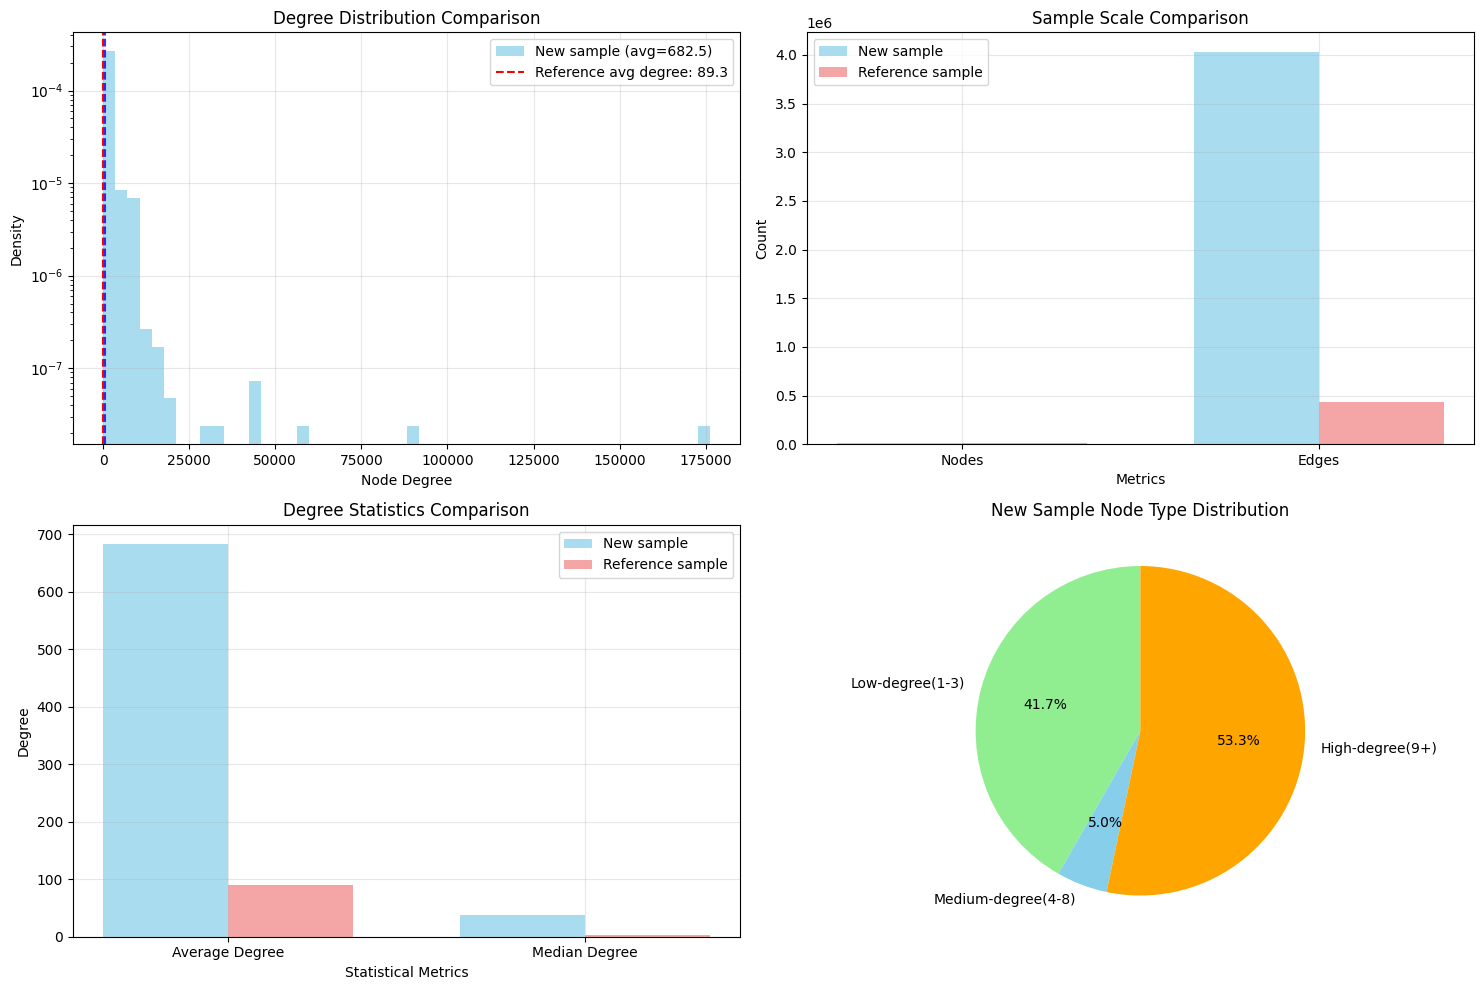


✅ Dataset_GAE large-scale sample generation completed!
🎯 Matching with reference sample:
    Node count: 11,810 (target: 8000-12000)
    Node count difference: 2,060
    Average degree: 682.48 (reference: 89.28)
    Average degree difference: 593.21

📝 Large-scale sampling method description:
  🎯 Goal-oriented: Ensure generation of 8000-12000 nodes
  🔗 Connectivity priority: Prioritize connected nodes
  ⚖️ Balanced strategy: High-degree nodes + random connected nodes
  🛡️ Scale protection: Limit isolated node removal


In [ ]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import random

def load_reference_sample():
    """Load statistical information from reference sample"""
    try:
        ref_path = "random_walk/training_subgraph_super_efficient_rw.pkl"
        with open(ref_path, 'rb') as f:
            ref_sample = pickle.load(f)
        
        degrees = list(dict(ref_sample.degree()).values())
        stats = {
            'num_nodes': ref_sample.number_of_nodes(),
            'num_edges': ref_sample.number_of_edges(),
            'avg_degree': np.mean(degrees),
            'median_degree': np.median(degrees)
        }
        
        print(f"Reference sample statistics:")
        print(f"  Nodes: {stats['num_nodes']:,}")
        print(f"  Edges: {stats['num_edges']:,}")
        print(f"  Average degree: {stats['avg_degree']:.2f}")
        print(f"  Median degree: {stats['median_degree']:.2f}")
        
        return stats
    except Exception as e:
        print(f"Cannot load reference sample: {e}")
        return None

def load_dataset_gae_training_subgraph():
    """Load Dataset_GAE training subgraph"""
    try:
        dataset_path = "Dataset_GAE/training_subgraph.pkl"
        with open(dataset_path, 'rb') as f:
            graph = pickle.load(f)
        
        print(f"Dataset_GAE training subgraph loaded successfully:")
        print(f"  Number of nodes: {graph.number_of_nodes():,}")
        print(f"  Number of edges: {graph.number_of_edges():,}")
        print(f"  Graph type: MultiGraph={graph.is_multigraph()}, Directed={graph.is_directed()}")
        
        return graph
    except Exception as e:
        print(f"Cannot load Dataset_GAE training subgraph: {e}")
        return None

def create_large_connected_sample(original_graph, target_nodes_min=8000, target_nodes_max=12000, target_avg_degree=89.28):
    """
    Create large-scale connected sample: ensure 8000-12000 nodes generation
    """
    print("=" * 60)
    print("Creating large-scale connected Dataset_GAE sample")
    print(f"Target node range: {target_nodes_min:,} - {target_nodes_max:,}")
    print(f"Reference average degree: {target_avg_degree:.2f}")
    print("=" * 60)
    
    # Get all nodes and their degrees
    all_nodes = list(original_graph.nodes())
    node_degrees = dict(original_graph.degree())
    
    print(f"Original graph statistics:")
    print(f"  Nodes: {original_graph.number_of_nodes():,}")
    print(f"  Edges: {original_graph.number_of_edges():,}")
    print(f"  Average degree: {np.mean(list(node_degrees.values())):.2f}")
    
    # Find all connected nodes (degree > 0)
    connected_nodes = [node for node in all_nodes if node_degrees[node] > 0]
    isolated_nodes = [node for node in all_nodes if node_degrees[node] == 0]
    
    print(f"\n🔍 Node analysis:")
    print(f"  Connected nodes: {len(connected_nodes):,}")
    print(f"  Isolated nodes: {len(isolated_nodes):,}")
    
    # Strategy: If enough connected nodes available, use most of them
    if len(connected_nodes) >= target_nodes_max:
        print(f"\n🎯 Strategy: Select {target_nodes_max:,} nodes from connected nodes")
        
        # Sort by degree, prioritize higher-degree nodes
        connected_by_degree = sorted(connected_nodes, key=lambda x: node_degrees[x], reverse=True)
        
        # Select top target_nodes_max nodes, but ensure some randomness
        # Choose top 50% high-degree nodes, then randomly select from remaining
        high_degree_count = target_nodes_max // 2
        remaining_count = target_nodes_max - high_degree_count
        
        selected_nodes = set(connected_by_degree[:high_degree_count])
        
        # Randomly select from remaining connected nodes
        remaining_connected = connected_by_degree[high_degree_count:]
        if remaining_connected and remaining_count > 0:
            additional_nodes = random.sample(
                remaining_connected, 
                min(remaining_count, len(remaining_connected))
            )
            selected_nodes.update(additional_nodes)
        
        print(f"  Selected {len(selected_nodes):,} nodes")
        print(f"    High-degree nodes: {high_degree_count:,}")
        print(f"    Random connected nodes: {len(selected_nodes) - high_degree_count:,}")
        
    elif len(connected_nodes) >= target_nodes_min:
        print(f"\n🎯 Strategy: Use all {len(connected_nodes):,} connected nodes")
        selected_nodes = set(connected_nodes)
    else:
        print(f"\n⚠️ Connected nodes ({len(connected_nodes):,}) less than minimum target ({target_nodes_min:,})")
        print(f"Strategy: Use all connected nodes + random isolated nodes supplement")
        
        # Use all connected nodes
        selected_nodes = set(connected_nodes)
        
        # Calculate how many more nodes needed
        need_more = target_nodes_min - len(connected_nodes)
        if need_more > 0 and isolated_nodes:
            additional_isolated = random.sample(
                isolated_nodes, 
                min(need_more, len(isolated_nodes))
            )
            selected_nodes.update(additional_isolated)
            print(f"  Added {len(additional_isolated):,} isolated nodes")
    
    # Create subgraph
    print(f"\n📊 Creating subgraph...")
    subgraph = original_graph.subgraph(selected_nodes).copy()
    
    initial_nodes = subgraph.number_of_nodes()
    initial_edges = subgraph.number_of_edges()
    
    print(f"  Initial subgraph:")
    print(f"    Nodes: {initial_nodes:,}")
    print(f"    Edges: {initial_edges:,}")
    
    # Check and remove isolated nodes (but ensure not too many are removed)
    isolated_in_subgraph = [node for node in subgraph.nodes() if subgraph.degree(node) == 0]
    
    # Only remove if isolated nodes are not too many
    max_removable = initial_nodes // 10  # Remove at most 10% of nodes
    
    if isolated_in_subgraph and len(isolated_in_subgraph) <= max_removable:
        print(f"  🔄 Removing {len(isolated_in_subgraph):,} isolated nodes (minor cleanup)")
        subgraph.remove_nodes_from(isolated_in_subgraph)
    elif isolated_in_subgraph:
        print(f"  ⚠️ Found {len(isolated_in_subgraph):,} isolated nodes, but keeping to maintain scale")
    
    final_nodes = subgraph.number_of_nodes()
    final_edges = subgraph.number_of_edges()
    
    print(f"  ✅ Final subgraph:")
    print(f"    Nodes: {final_nodes:,}")
    print(f"    Edges: {final_edges:,}")
    
    # Check if target range is achieved
    if target_nodes_min <= final_nodes <= target_nodes_max:
        print(f"    ✅ Node count within target range!")
    elif final_nodes < target_nodes_min:
        print(f"    ⚠️ Node count ({final_nodes:,}) less than minimum target ({target_nodes_min:,})")
    else:
        print(f"    ⚠️ Node count ({final_nodes:,}) exceeds maximum target ({target_nodes_max:,})")
    
    # Statistical information
    degrees = list(dict(subgraph.degree()).values())
    if degrees:
        avg_degree = np.mean(degrees)
        median_degree = np.median(degrees)
        std_degree = np.std(degrees)
        
        print(f"\n✅ Dataset_GAE large-scale sample created successfully!")
        print(f"🔸 Sample scale:")
        print(f"    Final node count: {final_nodes:,}")
        print(f"    Edge count: {final_edges:,}")
        print(f"    Sampling rate: {(final_nodes/original_graph.number_of_nodes())*100:.3f}%")
        
        print(f"🔸 Degree distribution:")
        print(f"    Average degree: {avg_degree:.2f}")
        print(f"    Difference from reference: {abs(avg_degree - target_avg_degree):.2f}")
        print(f"    Median degree: {median_degree:.2f}")
        print(f"    Standard deviation: {std_degree:.2f}")
        
        # Degree distribution analysis
        zero_degree = sum(1 for d in degrees if d == 0)
        low_degree = sum(1 for d in degrees if 1 <= d <= 3)
        medium_degree = sum(1 for d in degrees if 4 <= d <= 8)
        high_degree = sum(1 for d in degrees if d >= 9)
        
        print(f"🔸 Node type distribution:")
        if zero_degree > 0:
            print(f"    Isolated nodes (0): {zero_degree:,} ({zero_degree/final_nodes*100:.1f}%)")
        if low_degree > 0:
            print(f"    Low-degree (1-3): {low_degree:,} ({low_degree/final_nodes*100:.1f}%)")
        if medium_degree > 0:
            print(f"    Medium-degree (4-8): {medium_degree:,} ({medium_degree/final_nodes*100:.1f}%)")
        if high_degree > 0:
            print(f"    High-degree (9+): {high_degree:,} ({high_degree/final_nodes*100:.1f}%)")
        
        # Connectivity analysis
        if subgraph.is_directed():
            weak_components = list(nx.weakly_connected_components(subgraph))
            largest_component_size = max(len(comp) for comp in weak_components) if weak_components else 0
            
            print(f"🔸 Network connectivity:")
            print(f"    Weakly connected components: {len(weak_components):,}")
            print(f"    Largest component size: {largest_component_size:,} ({largest_component_size/final_nodes*100:.1f}%)")
        else:
            components = list(nx.connected_components(subgraph))
            largest_component_size = max(len(comp) for comp in components) if components else 0
            
            print(f"🔸 Network connectivity:")
            print(f"    Connected components: {len(components):,}")
            print(f"    Largest component size: {largest_component_size:,} ({largest_component_size/final_nodes*100:.1f}%)")
    
    return subgraph

def visualize_sample_comparison(original_sample, new_sample, ref_stats):
    """Visualize comparison between new sample and reference sample"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Get degree distribution
    new_degrees = list(dict(new_sample.degree()).values())
    
    # 1. Degree distribution comparison
    ax1.hist(new_degrees, bins=50, alpha=0.7, color='skyblue', 
             label=f'New sample (avg={np.mean(new_degrees):.1f})', density=True)
    ax1.axvline(np.mean(new_degrees), color='blue', linestyle='--', alpha=0.8)
    ax1.axvline(ref_stats['avg_degree'], color='red', linestyle='--', 
               label=f'Reference avg degree: {ref_stats["avg_degree"]:.1f}')
    ax1.set_xlabel('Node Degree')
    ax1.set_ylabel('Density')
    ax1.set_title('Degree Distribution Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # 2. Sample scale comparison
    categories = ['Nodes', 'Edges']
    new_values = [new_sample.number_of_nodes(), new_sample.number_of_edges()]
    ref_values = [ref_stats['num_nodes'], ref_stats['num_edges']]
    
    x = np.arange(len(categories))
    width = 0.35
    
    ax2.bar(x - width/2, new_values, width, label='New sample', color='skyblue', alpha=0.7)
    ax2.bar(x + width/2, ref_values, width, label='Reference sample', color='lightcoral', alpha=0.7)
    ax2.set_xlabel('Metrics')
    ax2.set_ylabel('Count')
    ax2.set_title('Sample Scale Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Degree statistics comparison
    stats_categories = ['Average Degree', 'Median Degree']
    new_stats = [np.mean(new_degrees), np.median(new_degrees)]
    ref_stats_values = [ref_stats['avg_degree'], ref_stats['median_degree']]
    
    x2 = np.arange(len(stats_categories))
    ax3.bar(x2 - width/2, new_stats, width, label='New sample', color='skyblue', alpha=0.7)
    ax3.bar(x2 + width/2, ref_stats_values, width, label='Reference sample', color='lightcoral', alpha=0.7)
    ax3.set_xlabel('Statistical Metrics')
    ax3.set_ylabel('Degree')
    ax3.set_title('Degree Statistics Comparison')
    ax3.set_xticks(x2)
    ax3.set_xticklabels(stats_categories)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Degree distribution pie chart
    isolated_count = sum(1 for d in new_degrees if d == 0)
    low_count = sum(1 for d in new_degrees if 1 <= d <= 3)
    medium_count = sum(1 for d in new_degrees if 4 <= d <= 8)
    high_count = sum(1 for d in new_degrees if d >= 9)
    
    sizes = [isolated_count, low_count, medium_count, high_count]
    labels = ['Isolated(0)', 'Low-degree(1-3)', 'Medium-degree(4-8)', 'High-degree(9+)']
    colors = ['gray', 'lightgreen', 'skyblue', 'orange']
    
    # Only show non-zero categories
    non_zero_indices = [i for i, size in enumerate(sizes) if size > 0]
    filtered_sizes = [sizes[i] for i in non_zero_indices]
    filtered_labels = [labels[i] for i in non_zero_indices]
    filtered_colors = [colors[i] for i in non_zero_indices]
    
    if filtered_sizes:
        ax4.pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors,
               autopct='%1.1f%%', startangle=90)
        ax4.set_title('New Sample Node Type Distribution')
    
    plt.tight_layout()
    plt.show()

# Execute large-scale sampling process
print("Starting large-scale Dataset_GAE sample creation (8000-12000 nodes)...")

# 1. Load reference sample statistics
ref_stats = load_reference_sample()

if ref_stats is not None:
    # 2. Load Dataset_GAE original data
    dataset_gae_graph = load_dataset_gae_training_subgraph()
    
    if dataset_gae_graph is not None:
        # 3. Use large-scale sampling method
        dataset_gae_sample = create_large_connected_sample(
            dataset_gae_graph,
            target_nodes_min=8000,
            target_nodes_max=12000,
            target_avg_degree=ref_stats['avg_degree']
        )
        
        if dataset_gae_sample is not None:
            # 4. Save sample to Dataset_GAE folder
            sample_filename = "training_subgraph_sample_large.pkl"
            sample_filepath = os.path.join("Dataset_GAE", sample_filename)
            
            with open(sample_filepath, 'wb') as f:
                pickle.dump(dataset_gae_sample, f)
            
            print(f"\n💾 Dataset_GAE large-scale sample saved:")
            print(f"    File path: {sample_filepath}")
            
            # Check file size
            file_size = os.path.getsize(sample_filepath) / (1024 * 1024)
            print(f"    File size: {file_size:.2f} MB")
            
            # 5. Visualization comparison analysis
            print(f"\n📊 Generating comparison analysis charts...")
            visualize_sample_comparison(dataset_gae_graph, dataset_gae_sample, ref_stats)
            
            print(f"\n✅ Dataset_GAE large-scale sample generation completed!")
            print(f"🎯 Matching with reference sample:")
            print(f"    Node count: {dataset_gae_sample.number_of_nodes():,} (target: 8000-12000)")
            print(f"    Node count difference: {abs(dataset_gae_sample.number_of_nodes() - ref_stats['num_nodes']):,}")
            
            sample_avg = np.mean(list(dict(dataset_gae_sample.degree()).values()))
            print(f"    Average degree: {sample_avg:.2f} (reference: {ref_stats['avg_degree']:.2f})")
            print(f"    Average degree difference: {abs(sample_avg - ref_stats['avg_degree']):.2f}")
            
            print(f"\n📝 Large-scale sampling method description:")
            print(f"  🎯 Goal-oriented: Ensure generation of 8000-12000 nodes")
            print(f"  🔗 Connectivity priority: Prioritize connected nodes")
            print(f"  ⚖️ Balanced strategy: High-degree nodes + random connected nodes")
            print(f"  🛡️ Scale protection: Limit isolated node removal")
            
        else:
            print("❌ Dataset_GAE large-scale sample creation failed!")
    else:
        print("❌ Cannot load Dataset_GAE/training_subgraph.pkl!")
else:
    print("❌ Cannot load reference sample statistics!")